Script for performing Multi-Crteria Decision Making analysis to evaluate the huts. Steps:
1. Create the 'alternatives' dataframe by aggregating information on the various criteria (water, energy, etc.)
    
    1.1 convert qualitative data in quantittive using a scoring system

2. perform MCDM analysis with ‘pymcdm` library (compare different methods)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import rasterio
import random
import seaborn as sns
from tabulate import tabulate

import functions as fun

import warnings
warnings.simplefilter("ignore")

# Create geodataframe

In [2]:
huts_points = gpd.read_file('../data/huts/huts_points.geojson')
huts_points = huts_points.to_crs(epsg=32632) # convert to UTM32N [m] for analysis
huts_points.head(5)

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,aerialway,aerialways,geometry
0,alpepozzavlancia,"ALPE POZZA ""VINCENZO LANCIA""",C,Alp,50,1802,0.0,None,POINT (666584.351 5077095.370)
1,altissimodchiesa,"ALTISSIMO ""DAMIANO CHIESA""",C,Alp,35,2060,0.0,None,POINT (646874.183 5074717.942)
2,antermoia,ANTERMOIA,D,Alp,61,2496,0.0,goods,POINT (704489.000 5150499.000)
3,bindesipprati,"BINDESI ""PINO PRATI""",A,Escurs,0,618,0.0,None,POINT (666672.806 5100323.693)
4,boccaditratnpernici,"BOCCA DI TRAT ""NINO PERNICI""",C,Alp,28,1601,0.0,None,POINT (637133.000 5087416.000)


## Water criteria
Source: SAT's archive

Criteria:
- type of water source
- water storage capacity

In [3]:
appr_idrico = pd.read_csv('../data/water/sat_appr_idrico.csv')
# Replace -999 with NaN
appr_idrico.replace(-999, np.nan, inplace=True)
appr_idrico.replace('-999', np.nan, inplace=True)

CR_WA_01. TYPE OF SOURCE

In [4]:
# Merge huts_points with appr_idrico 
merged_df = huts_points.merge(appr_idrico[['standard_name', 'acquedotto', 'sorgente', 'superficiale', 'cisterna_m3']], on='standard_name', how='left')

# Define the function to create the CR_WA_01 column
def determine_CR_WA_01(row):
    if row['acquedotto'] == 1:
        return 'aqueduct'
    elif row['sorgente'] == 1:
        return 'spring'
    elif pd.notna(row['superficiale']):
        if row['superficiale'] == '0':
            return 'nosource'
        return row['superficiale']
    else:
        return np.nan

# Apply the function to create the CR_WA_01 column
merged_df['CR_WA_01'] = merged_df.apply(determine_CR_WA_01, axis=1)
merged_df.CR_WA_01.value_counts()


CR_WA_01
spring       9
aqueduct     6
fusione      6
torr-rio     5
torr-lago    2
lago         2
misto        1
lago-torr    1
nosource     1
Name: count, dtype: int64

CR_WA_02. WATER STORAGE CAPACITY [m3]

In [5]:
def process_cisterna_m3(value):
    try:
        if isinstance(value, str)and '+' in value:
            # split the value by '+' and convert to integers, then sum them
            return sum(map(int, value.split('+')))
        else:
            # convert the value to a float
            return float(value)
    except ValueError:
        # if conversion fails, return NaN
        return np.nan

merged_df['CR_WA_02'] = merged_df['cisterna_m3'].apply(process_cisterna_m3)

## Energy & electricity
Source: SAT's report on energy (2021)

Criteria:
- Type of energy source(s)
- Number of energy sources
- Power storage capacity
- Heating source

In [6]:
appr_energia = pd.read_csv('../data/others/sat_appr_energetico.csv')
appr_energia.head(5)

,rifugio,categoria_CAISAT,categoria_PAT,quota,posti_letto,cogeneratore,generatore,potenza_gruppoel_kw,riserva,fotovoltaico,potenza_fotov_kw,accumulo_fotov_V,accumulo_fotov_ah,idroelettrico,potenza_idro_kw,rete_elettrica,gas_gpl,solare_termico,riscaldamento,note
0,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,0,1,40,1,1,1.8,24,1500,0,0,0,1,0,gasolio,NaN
1,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,0,1,20,1,1,2.5,48,1000,0,0,0,1,0,-999,NaN
2,Antermoia,D,Alp,2.496,61,1,0,60,1,1,1.4,24,1580,0,0,0,1,0,gasolio,NaN
3,"Bindesi - ""P.Prati""",A,Escurs.,611.000,0,0,0,0,0,0,0.0,0,0,0,0,1,1,0,-999,NaN
4,"Bocca di Trat - ""N.Pernici""",C,Alp,1.600,28,0,1,40,1,1,1.2,24,1200,0,0,0,1,0,-999,NaN


In [7]:
# Replace -999 with NaN
appr_energia.replace(-999, np.nan, inplace=True)
appr_energia.replace('-999', np.nan, inplace=True)
# Standardize names
appr_energia['standard_name'] = appr_energia['rifugio'].apply(fun.standardize_name)
# fix xii apostoli
appr_energia.loc[appr_energia['standard_name'] == '1iiapostoliflligarbari', 'standard_name'] = 'xiiapostoliflligarbari'

In [8]:
appr_energia.columns

Index(['rifugio', 'categoria_CAISAT', 'categoria_PAT', 'quota', 'posti_letto',
       'cogeneratore', 'generatore', 'potenza_gruppoel_kw', 'riserva',
       'fotovoltaico', 'potenza_fotov_kw', 'accumulo_fotov_V',
       'accumulo_fotov_ah', 'idroelettrico', 'potenza_idro_kw',
       'rete_elettrica', 'gas_gpl', 'solare_termico', 'riscaldamento', 'note',
       'standard_name'],
      dtype='object')

CR_EN_01. TYPE OF SOURCE

In [9]:
# Merge with appr_energia
merged_df = merged_df.merge(appr_energia[['standard_name', 'cogeneratore', 'generatore', 'potenza_gruppoel_kw', 'riserva',
       'fotovoltaico', 'potenza_fotov_kw', 'accumulo_fotov_V',
       'accumulo_fotov_ah', 'idroelettrico', 'potenza_idro_kw',
       'rete_elettrica', 'gas_gpl', 'solare_termico', 'riscaldamento']], 
       on='standard_name', how='left')

def determine_energy(row):
    res = []
    if row['cogeneratore'] == 1:
        res.append('cogenerator')
    if row['generatore'] == 1:
        res.append('generator')
    if row['fotovoltaico'] == 1:
        res.append('photovoltaic')
    if row['idroelettrico'] == 1:
        res.append('hydroelectric')
    if row['rete_elettrica'] == 1:
        res.append('public_electricity')
    if row['gas_gpl'] == 1:
        res.append('gas')
    if row['solare_termico'] == 1:
        res.append('solar_thermal')
    if res == []:
        return np.nan
    else:
        return res

# Apply the function to create the column
merged_df['CR_EN_01'] = merged_df.apply(determine_energy, axis=1)

CR_EN_02. NUMBER OF SOURCES

In [10]:
merged_df['CR_EN_02'] = merged_df['CR_EN_01'].apply(len)

CR_EN_03. POWER STORAGE CAPACITY

In [11]:
# Sum of kw from all sources
# Note: potenza_gruppoel_kw is of type object because it has sums 
def determine_capacity(row):
    res = 0
    for col in ['potenza_gruppoel_kw', 'potenza_fotov_kw', 'potenza_idro_kw']:
        try:
            if isinstance(row[col], str) and '+' in row[col]:
                # split the value by '+' and convert to integers, then sum them
                res += sum(map(int, row[col].split('+')))
            else:
                # convert the value to a float
                res += float(row[col])
        except ValueError:
            return np.nan

    return res

merged_df['CR_EN_03'] = merged_df.apply(determine_capacity, axis=1)

In [12]:
merged_df.CR_EN_03.unique()
# the ones at 0 are the 8 connected to public electricity

array([ 41.8,  22.5,  61.4,   0. ,  41.2,  25. ,  21. ,  40. ,   7. ,
       120. ,   6. ,  43.2,  26.5,   8. ,  29.2,  80. , 840. ,  30. ,
        21.3,  26.3])

CR_EN_04. HEATING

It can be electric or with gpl. Some huts had no data, so I check the electricity sources to see if there are renewables or the public electricity that could be used for heating. 

In [13]:
merged_df['CR_EN_04'] = merged_df['riscaldamento']

In [14]:
for idx, row in merged_df.iterrows():
    if row['CR_EN_04'] != 'elettrico' and row['CR_EN_04'] != 'gasolio':
        energy_sources = row['CR_EN_01']
        renewable_sources = ['hydroelectric', 'solar_thermal', 'photovoltaic']
        ren_options = [source for source in energy_sources if source in renewable_sources]
        # check renewables
        if ren_options:
            print(f"Found a renewable heating option! {ren_options} in {row['standard_name']}")
            merged_df.at[idx, 'CR_EN_04'] = 'renewable_option'
        # check public electricity
        elif 'public_electricity' in energy_sources:
            print(f"Found a public electricity for heating! In {row['standard_name']}")
            merged_df.at[idx, 'CR_EN_04'] = 'public_electricity'

Found a renewable heating option! ['photovoltaic'] in altissimodchiesa
Found a public electricity for heating! In bindesipprati
Found a renewable heating option! ['photovoltaic'] in boccaditratnpernici
Found a renewable heating option! ['photovoltaic'] in casarotalciola
Found a public electricity for heating! In ciampediè
Found a renewable heating option! ['hydroelectric'] in cimadastaobrentari
Found a renewable heating option! ['photovoltaic'] in fftucketteqsella
Found a public electricity for heating! In finonchiofllifilzi
Found a renewable heating option! ['solar_thermal'] in montecalinosanpietro
Found a public electricity for heating! In paludei
Found a renewable heating option! ['photovoltaic', 'solar_thermal'] in peller
Found a renewable heating option! ['photovoltaic'] in rodadivael
Found a renewable heating option! ['hydroelectric'] in stavelfdenza
Found a renewable heating option! ['photovoltaic'] in valdambiezsagostini
Found a renewable heating option! ['hydroelectric'] in va

In [15]:
merged_df['CR_EN_04'].value_counts(dropna=False)

CR_EN_04
renewable_option      14
gasolio                7
elettrico              6
public_electricity     4
NaN                    2
Name: count, dtype: int64

In [16]:
merged_df[merged_df['CR_EN_04'].isna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,aerialway,aerialways,geometry,acquedotto,...,idroelettrico,potenza_idro_kw,rete_elettrica,gas_gpl,solare_termico,riscaldamento,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04
25,tosaetpedrotti,"TOSA ""TOMMASO PEDROTTI""",D,Alp,140,2500,0.0,goods,POINT (646611.171 5112931.074),0.0,...,0.0,0.0,0.0,1.0,0.0,NaN,"[cogenerator, gas]",2,80.0,NaN
31,vioz,"VIOZ ""MANTOVA""",E,Alp,60,3531,NaN,visitors,POINT (625753.000 5139701.000),0.0,...,0.0,0.0,0.0,1.0,0.0,NaN,"[cogenerator, gas]",2,80.0,NaN


## Supplies
Sources: OSM (aerialways and roads), SAT's archives (helicopters).

Criteria: mode(s) of hut supplying.



GOODS AERIALWAYS

Load the goods_aerialways gdf (Multilinestrings) and for each hut check if an aerialway arrives within a 500m radius.

In [17]:
goods_aerialways = gpd.read_file('../data/others/goods_aerialways.geojson')
goods_aerialways = goods_aerialways.to_crs(merged_df.crs)

In [18]:
# Function to get IDs of intersecting goods aerialways
def get_goods_aerialway_ids(hut_buffer):
    intersecting_goods = goods_aerialways[goods_aerialways.intersects(hut_buffer)]
    if not intersecting_goods.empty:
        return set(intersecting_goods['id'])  # Collect IDs of intersecting goods aerialways
    else:
        return None

# Buffer the huts points by 500 meters
merged_df['buffer'] = merged_df.geometry.buffer(500)

# Check for intersections between the buffered huts and the aerialways
merged_df['supply_aerialway'] = merged_df['buffer'].apply(
    lambda hut_buffer: goods_aerialways.intersects(hut_buffer).any()
)
# Find intersecting goods aerialways and store their IDs
merged_df['goods_aerialway_ids'] = merged_df['buffer'].apply(get_goods_aerialway_ids)
merged_df = merged_df.drop(columns=['buffer'])

# Collect all unique goods aerialway IDs and filter aerialways gdf
connected_goods_ids = merged_df['goods_aerialway_ids'].explode().dropna().unique()
filtered_goods_gdf = goods_aerialways[goods_aerialways['id'].isin(connected_goods_ids)]
# save to file for QGIS
filtered_goods_gdf.to_file('../data/others/connected_goods.geojson', driver="GeoJSON")

# Values of the new column
merged_df.supply_aerialway.value_counts()

supply_aerialway
False    18
True     15
Name: count, dtype: int64

In [19]:
# Function to get IDs of intersecting goods aerialways
def get_goods_aerialway_ids(hut_buffer):
    intersecting_goods = goods_aerialways[goods_aerialways.intersects(hut_buffer)]
    if not intersecting_goods.empty:
        return set(intersecting_goods['id'])  # Collect IDs of intersecting goods aerialways
    else:
        return None

# Buffer the huts points by 500 meters
merged_df['buffer_500'] = merged_df.geometry.buffer(500)

# Find intersecting goods aerialways and store their IDs
merged_df['goods_aerialway_ids'] = merged_df['buffer_500'].apply(get_goods_aerialway_ids)

# Drop the temporary buffer column
merged_df = merged_df.drop(columns=['buffer_500'])

# Collect all unique goods aerialway IDs
all_goods_ids = merged_df['goods_aerialway_ids'].explode().dropna().unique()

# Filter the goods aerialways GeoDataFrame using the collected IDs
filtered_goods_gdf = goods_aerialways[goods_aerialways['id'].isin(all_goods_ids)]

# Save the result as a GeoJSON file
output_filepath_goods = "goods_aerialways_at_huts.geojson"
filtered_goods_gdf.to_file(output_filepath_goods, driver="GeoJSON")

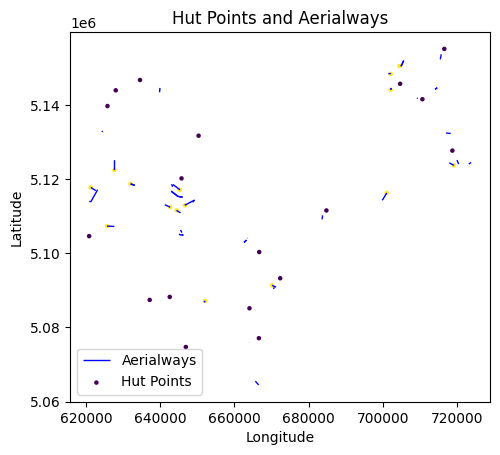

In [20]:
# Plot the hut points and aerialways
fig, ax = plt.subplots()

goods_aerialways.plot(ax=ax, color='blue', linewidth=1, label='Aerialways')
merged_df.plot(ax=ax, c=merged_df['supply_aerialway'], markersize=5, label='Hut Points')

plt.legend()
plt.title('Hut Points and Aerialways')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

HELICOPTER

Huts using helicopter for supplying are: Cevedale, Dorigoni, Stivo, Val di Fumo, Boè, Sette Selle, Rosetta, Vioz (Source: SAT)

In [21]:
heli = ['cevedaleglarcher', 'saentsdorigoni', 'stivopmarchetti', 'valdifumo', 'boè', 'setteselle', 'rosettagpedrotti', 'vioz']

def define_helicopter_supply(row):
    if row['standard_name'] in heli:
        return True
    else:
        return False

merged_df['supply_helicopter'] = merged_df.apply(define_helicopter_supply, axis=1)
merged_df['supply_helicopter'].value_counts()


supply_helicopter
False    25
True      8
Name: count, dtype: int64

ROADS

For each hut, use the Point geometry to get the network of roads connected to it. Check the road types: if a car-road is there, I assume it is used for supplying. Most of them are of 'track' type which represents strade forestali, which makes sense.

In [22]:
# Buffer distance in meters to search for roads near the hut
buffer_dist = 300  # (more than 300 becomes less accurate (gets Stivo which does not have car access))
huts_with_road = {}

merged_df4326 = merged_df.to_crs(epsg=4326) # OSMnx uses WGS84 [degrees] 
for idx, hut in merged_df4326.iterrows():
    hut_point = hut.geometry

    # Get network of roads within a certain distance from the hut's location
    roads_gdf = ox.features.features_from_point(
        (hut_point.y, hut_point.x),
        tags={'highway': True},  # Fetch all roads with 'highway' tag
        dist=buffer_dist
    )

    # Filter vehicle roads (OSM docs key:highway)
    roads_for_vehicles = ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'service', 'track'] # track=forestale/agricola
    vehicle_roads = roads_gdf[roads_gdf['highway'].isin(roads_for_vehicles)]
    
    if not vehicle_roads.empty:
      huts_with_road[hut['standard_name']] = vehicle_roads['highway'].unique()

for idx, row in merged_df.iterrows():
    if row['standard_name'] in huts_with_road:
        merged_df.at[idx, 'supply_road'] = True
    else:
        merged_df.at[idx, 'supply_road'] = False


CR_SU_01. Supply modes

In [23]:
# Combine all supply modes in a single column
def combine_supply_modes(row):
    supply_mode = []
    if row['supply_aerialway']:
        supply_mode.append('aerialway')
    if row['supply_helicopter']:
        supply_mode.append('helicopter')
    if row['supply_road']:
        supply_mode.append('vehicle')
    elif supply_mode == []:
        supply_mode.append('foot')
        
    return supply_mode

merged_df['CR_SU_01'] = merged_df.apply(combine_supply_modes, axis=1)
merged_df['CR_SU_01'].value_counts()

CR_SU_01
[vehicle]                  11
[aerialway]                11
[helicopter]                7
[aerialway, vehicle]        3
[aerialway, helicopter]     1
Name: count, dtype: int64

## Waste waters


CR_SU_02

Following Beltramo & Duglio (2016) classification. They divide between:
- Imhoff tank or septic tank
- sewage to valley
In addition, the presence of grease separator and/or grid can be added bonus.

Oppio & Bottero (2018) give a higher rating to sewage rather than onsite treatment (see scoring section).


In [24]:
waste_df = pd.read_csv('../data/others/sat_waste_management.csv')
waste_df['standard_name'] = waste_df['rifugio'].apply(fun.standardize_name)
waste_df = waste_df.map(lambda x: True if x == 'x' else x)
waste_df.head(5)

,rifugio,vasca_imhoff,fognatura_valle,depuratore,grigliatura,dispersione,disoleatore,note,standard_name
0,"Alpe Pozza - ""V.Lancia""",True,NaN,True,NaN,NaN,True,NaN,alpepozzavlancia
1,"Altissimo - ""D.Chiesa""",True,True,NaN,NaN,NaN,True,NaN,altissimodchiesa
2,Antermoia,NaN,NaN,NaN,True,True,True,NaN,antermoia
3,"Bindesi - ""P.Prati""",NaN,True,NaN,NaN,NaN,NaN,NaN,bindesipprati
4,"Bocca di Trat - ""N.Pernici""",True,NaN,NaN,NaN,True,NaN,NaN,boccaditratnpernici


In [25]:
def define_waste_mgm(row, waste_df):
    waste_hutrow = waste_df.loc[waste_df['standard_name'] == row['standard_name']]
    res = []
    if not waste_hutrow.empty and waste_hutrow['vasca_imhoff'].any():
        res.append('imhoff_tank')
    if not waste_hutrow.empty and waste_hutrow['dispersione'].any():
        res.append('septic_tank')
    if not waste_hutrow.empty and waste_hutrow['fognatura_valle'].any():
        res.append('sewage')
    if not waste_hutrow.empty and waste_hutrow['grigliatura'].any():
        res.append('grid')
    if not waste_hutrow.empty and waste_hutrow['disoleatore'].any():
        res.append('grease_separator')

    return res

merged_df['CR_SU_02'] = merged_df.apply(define_waste_mgm, axis=1, args=(waste_df,))
merged_df['CR_SU_02'].value_counts()



CR_SU_02
[septic_tank, grid, grease_separator]           18
[sewage]                                         6
[imhoff_tank, septic_tank]                       4
[imhoff_tank, sewage, grease_separator]          2
[imhoff_tank, grease_separator]                  1
[sewage, grease_separator]                       1
[imhoff_tank, septic_tank, grease_separator]     1
Name: count, dtype: int64

## Accessibility
Sources: OSM (lifts), PAT (trails), SAT (remoteness categories)

Criteria:
- type of accesses
- number of accesses 
- remoteness


CR_AC_01. TYPE OF ACCESS

-> Lifts

From looking in QGIS: there are 3 types of geometries (point, linestring and polygon). Points and polygons are the stations. However, not all lifts have a marked station, so for analysis it may be better to use the linestring (as done with goods aerialways).

I will distinguish between two types of access by lift:
- huts directly accessible via lift (within a 500m (~ 10min) radius from the hut)
- huts with facilitated access thanks to a lift (within a 2.3km radius from the hut)

In [26]:
lifts_aerialways = gpd.read_file('../data/others/lifts_aerialways.geojson')
lifts_aerialways = lifts_aerialways.to_crs(merged_df.crs)

In [27]:
def get_lift_ids_within_buffer(hut_buffer):
    lifts_aerialways_linestring = lifts_aerialways[lifts_aerialways.geometry.type == 'LineString']
    intersecting_lifts = lifts_aerialways_linestring[lifts_aerialways_linestring.intersects(hut_buffer)]
    if not intersecting_lifts.empty:
        # Return all the lift IDs that intersect within the 2300m buffer
        return set(intersecting_lifts['id'])
    else:
        return None

# Directly accessible via lift
merged_df['buffer_500'] = merged_df.geometry.buffer(500)
merged_df['lift_ids_within_500m'] = merged_df['buffer_500'].apply(get_lift_ids_within_buffer)
merged_df = merged_df.drop(columns=['buffer_500'])

# Simplified accessibility via lift
merged_df['buffer_2300'] = merged_df.geometry.buffer(2300)
merged_df['lift_ids_within_2300m'] = merged_df['buffer_2300'].apply(get_lift_ids_within_buffer)
merged_df = merged_df.drop(columns=['buffer_2300'])


In [28]:
# unique connected lifts ids
connected_lifts_ids = merged_df[['lift_ids_within_500m', 'lift_ids_within_2300m']].stack().explode().dropna().unique()
# filter lifts gdf
filtered_lifts_gdf = lifts_aerialways[lifts_aerialways['id'].isin(connected_lifts_ids)]
# save for QGIS
filtered_lifts_gdf.to_file("../data/others/connected_lifts.geojson",driver="GeoJSON")

For simplicity, for the moment I do not consider the difficulty of the itinerary connecting the lift to the hut. This because the a distance of 2km does not allow much variablity, and the presence of the lift already makes access easier. Note that I checked all the lifts are actually connected to the hut.

In [29]:
merged_df[merged_df['lift_ids_within_500m'].notna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,aerialway,aerialways,geometry,acquedotto,...,CR_EN_03,CR_EN_04,supply_aerialway,goods_aerialway_ids,supply_helicopter,supply_road,CR_SU_01,CR_SU_02,lift_ids_within_500m,lift_ids_within_2300m
9,ciampediè,CIAMPEDIE',B,Alp,25,1993,0.0,visitors,POINT (704674.062 5145698.588),1.0,...,0.0,public_electricity,False,None,False,True,[vehicle],[sewage],"{30792512, 30791793, 30792355, 151641974}","{30792512, 30792482, 30792355, 30792484, 30791..."
13,grostèggraffer,GIORGIO GRAFFER AL GROSTE',C,Alp,70,2261,0.0,visitors,POINT (645717.304 5120189.926),0.0,...,0.0,gasolio,False,None,False,True,[vehicle],"[imhoff_tank, sewage, grease_separator]","{42447792, 47405266, 327015525}","{27176128, 327015525, 42447792, 47405266, 3270..."


In [30]:
merged_df[merged_df['lift_ids_within_2300m'].notna()]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,aerialway,aerialways,geometry,acquedotto,...,CR_EN_03,CR_EN_04,supply_aerialway,goods_aerialway_ids,supply_helicopter,supply_road,CR_SU_01,CR_SU_02,lift_ids_within_500m,lift_ids_within_2300m
5,boè,BOE',D,Alp,80,2871,0.0,visitors,POINT (716585.416 5155102.852),0.0,...,0.0,gasolio,False,None,True,False,[helicopter],"[sewage, grease_separator]",None,{4702284}
9,ciampediè,CIAMPEDIE',B,Alp,25,1993,0.0,visitors,POINT (704674.062 5145698.588),1.0,...,0.0,public_electricity,False,None,False,True,[vehicle],[sewage],"{30792512, 30791793, 30792355, 151641974}","{30792512, 30792482, 30792355, 30792484, 30791..."
13,grostèggraffer,GIORGIO GRAFFER AL GROSTE',C,Alp,70,2261,0.0,visitors,POINT (645717.304 5120189.926),0.0,...,0.0,gasolio,False,None,False,True,[vehicle],"[imhoff_tank, sewage, grease_separator]","{42447792, 47405266, 327015525}","{27176128, 327015525, 42447792, 47405266, 3270..."
14,mandroncittàditrento,"MANDRON ""CITTA' DI TRENTO""",D,Alp,89,2445,0.0,both,POINT (621213.949 5117752.751),0.0,...,25.0,elettrico,True,{831285054},False,False,[aerialway],"[septic_tank, grid, grease_separator]",None,"{32873521, 823434783}"
19,rodadivael,RODA DI VAEL,C,Alp,60,2282,0.0,both,POINT (702109.109 5144095.471),1.0,...,61.4,renewable_option,True,{372648882},False,False,[aerialway],"[septic_tank, grid, grease_separator]",None,{4699599}
20,rosettagpedrotti,"ROSETTA ""GIOVANNI PEDROTTI""",C,Alp,78,2578,0.0,visitors,POINT (718762.299 5127676.973),0.0,...,40.0,elettrico,False,None,True,False,[helicopter],[sewage],None,"{39275726, 39275727}"
31,vioz,"VIOZ ""MANTOVA""",E,Alp,60,3531,NaN,visitors,POINT (625753.000 5139701.000),0.0,...,80.0,NaN,False,None,True,False,[helicopter],"[septic_tank, grid, grease_separator]",None,{181081515}


-> Public roads
Use the categoria_PAT column (if "Escurs" then is accessible by car for visitors)

In [31]:
merged_df['car_access'] = merged_df['categoria_PAT'].apply(lambda x: True if x == 'Escurs' else False)

-> Hiking trails
- number of arrival trails

In [32]:
# Buffer hut points by 300 meters and check intersections with trails_gdf
trails_gdf = gpd.read_file('../data/trails/Sentieri_della_SAT.shp')
trails_gdf = trails_gdf.to_crs(merged_df.crs)

# Create a new column 'arrival_trails' to store the names of intersecting trails
merged_df['arrival_trails'] = None

for idx, row in merged_df.iterrows():
    hut_buffer = row['geometry'].buffer(300)
    intersecting_trails = trails_gdf[trails_gdf.intersects(hut_buffer)]
    trail_names = list(intersecting_trails['numero'].unique())
    if trail_names:
        merged_df.at[idx, 'arrival_trails'] = trail_names
    else:
        merged_df.at[idx, 'arrival_trails'] = None

In [33]:
# Combine in a single column
def combine_accesses(row):
    access_mode = []
    if row['car_access']:
        access_mode.append('car')
    if row['arrival_trails']:
        access_mode.append('trail')
    if row['lift_ids_within_500m']:
        access_mode.append('lift_500m')
    if row['lift_ids_within_2300m']:
        access_mode.append('lift_2300m')
    return access_mode

merged_df['CR_AC_01'] = merged_df.apply(combine_accesses, axis=1)

CR_AC_02. NUMBER OF ACCESSES

In [34]:
# Count distinct modes of access (e.g. only car, etc.)
merged_df['CR_AC_02'] = merged_df['CR_AC_01'].apply(len)

CR_AC_03. REMOTENESS

Assessed using the categoria_CAISAT column. This consists of a classification (for the summer season) in 5 classes (A, B, C, D, E) based on **ease of access for hikers** and **ease of access for supplying**. (Regolamento strutture ricettiva del Club Alpino Italiano, p. 7)

- A: rifugi raggiungibili dalla clientela con auto privata o con massimo 10 minuti a piedi dal parcheggio. Sono incluse anche situazioni dove il cliente raggiunge il rifugio (o le immediate vicinanze) pagando un ticket. 
- B: rifugi raggiungibili con impianto a fune, o nelle strette vicinanze (entro i 10 minuti a piedi dall’arrivo dell’impianto); 
- C, D, E: varia in base a ore di cammino (x escursionista) da tabella CAI (vedi Regolamento). Per quanto riguarda il mezzo di trasporto dei rifornimenti/attrezzature, si assume che il costo in elicottero è il più elevato mentre la teleferica ha un costo una tantum ed ammortizzabile su più anni.

This can be easily converted to numbers from 1 (least remote) to 5 (most remote).


In [35]:
conversion_dict = {
    'A':1,
    'B':2,
    'C':3,
    'D':4,
    'E':5, 
}

# uniform values
merged_df['categoria_CAISAT'] = merged_df['categoria_CAISAT'].str.strip().str.upper()
merged_df['CR_AC_03'] = merged_df['categoria_CAISAT'].map(conversion_dict)

## Hospitality
Sources: SAT's archive

Criteria:
- overnight capacity
- seasonal affluence


CR_HO_01. OVERNIGHT CAPACITY

In [36]:
merged_df['CR_HO_01'] = merged_df['posti_letto']

CR_HO_02. SEASONAL OVERNIGHT STAYS (2022)

Extract from sat_pernottamenti.csv


In [37]:
pernottamenti = pd.read_csv('../data/others/sat_pernottamenti.csv')
pernottamenti['standard_name'] = pernottamenti['rifugio'].apply(fun.standardize_name)
merged_df['CR_HO_02'] = merged_df.merge(pernottamenti[['standard_name', '2022']], on='standard_name', how='left')['2022']

# Manually set mis-matched names
merged_df.loc[merged_df['standard_name'] == 'casarotalciola', 'CR_HO_02'] = 102
merged_df.loc[merged_df['standard_name'] == 'fftucketteqsella', 'CR_HO_02'] = 4883
merged_df.loc[merged_df['standard_name'] == 'saentsdorigoni', 'CR_HO_02'] = 2283
merged_df.loc[merged_df['standard_name'] == 'stavelfdenza', 'CR_HO_02'] = 903
merged_df.loc[merged_df['standard_name'] == 'vioz', 'CR_HO_02'] = 1318
merged_df.loc[merged_df['standard_name'] == 'xiiapostoliflligarbari', 'CR_HO_02'] = 1100

In [38]:
#merged_df.to_parquet('../data/alternatives_unfiltered.parquet')

## Select only criterias, name and geometry

In [39]:
criteria_cols = [col for col in merged_df.columns if 'CR_' in col and 'HO' not in col]
alternatives_gdf = merged_df[['standard_name', 'geometry'] + criteria_cols]
alternatives_gdf.head(5)

,standard_name,geometry,CR_WA_01,CR_WA_02,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,CR_SU_01,CR_SU_02,CR_AC_01,CR_AC_02,CR_AC_03
0,alpepozzavlancia,POINT (666584.351 5077095.370),spring,40.0,"[generator, photovoltaic, gas]",3,41.8,gasolio,[vehicle],"[imhoff_tank, grease_separator]",[trail],1,3
1,altissimodchiesa,POINT (646874.183 5074717.942),spring,30.0,"[generator, photovoltaic, gas]",3,22.5,renewable_option,[vehicle],"[imhoff_tank, sewage, grease_separator]",[trail],1,3
2,antermoia,POINT (704489.000 5150499.000),torr-lago,18.0,"[cogenerator, photovoltaic, gas]",3,61.4,gasolio,"[aerialway, vehicle]","[septic_tank, grid, grease_separator]",[trail],1,4
3,bindesipprati,POINT (666672.806 5100323.693),aqueduct,NaN,"[public_electricity, gas]",2,0.0,public_electricity,[vehicle],[sewage],"[car, trail]",2,1
4,boccaditratnpernici,POINT (637133.000 5087416.000),spring,20.0,"[generator, photovoltaic, gas]",3,41.2,renewable_option,[vehicle],"[imhoff_tank, septic_tank]",[trail],1,3


In [40]:
#alternatives_gdf.to_parquet('../data/alternatives_qual.parquet')

# Convert qualitative data
Qualitative columns like CR_WA_01 (water source) need to be converted in quantitative data. 

I defined some scoring systems based on existing literature. The main principle is environmental sustainability.

|criteria|description|conversion|cost/benefit*|
|---|---|---|---|
|**Type of water source**|string|Score based on reliability. From least to most reliable: nosource (0), fusion (glacier/snow) (1), lake/river (2), spring (3), public water (4).|benefit|
|**Type of energy source**|list of strings|Score based on environmental sustainability. From least to most sustainable: gpl and/or (co)generator (1), public electricity (2), renewables (photovoltaic, solar-thermal, hydroelectric) (3) → final score is the mean of all sources for the hut.|benefit|
|**Type of heating**|string|Score based on environmental sustainability. From least to most sustainable: gas (1), renewable_option* (2), electric (3), public_electricity (4)|benefit|
|**Mode of supplying**|list of strings|Score based on environmental sustainability. From least to most sustainable: helicopter (1), vehicle (2), foot or aerialway (3). → final score is the mean of all modes for the hut (same as energy sources).|benefit|
|**Waste waters management**|list of strings|Score based on Oppio & Bottero (2016), each mode is assigned a score, which are then summed. Best situations have a higher score: imhoff_tank and septic_tank (1), sewage (2), grease_separator and grid (0.50) are extras |benefit|
|**Type of accesses**|list of strings|Score based on difficulty of access.  From easier to harder access: public road (1), lifts (2), hiking trails (3). → final score is the mean of all accesses for the hut (same as above).|cost|

*cost/benefit: in MCDM each criteria is either a cost (aim at minimize) or a benefit (aim at maximize).

In [41]:
# Water source
water_source_map = {
    'nosource':0,
    'fusione':1,
    'lago':2,
    'torr-lago':2,
    'lago-torr':2,
    'torr-rio':2,
    'misto':2,
    'spring':3,
    'aqueduct':4
}

alternatives_gdf_qnt = alternatives_gdf.copy()
for idx, row in alternatives_gdf_qnt.iterrows():
    if row['CR_WA_01'] in water_source_map:
        alternatives_gdf_qnt.at[idx, 'CR_WA_01'] = water_source_map[row['CR_WA_01']]
    else:
        alternatives_gdf_qnt.at[idx, 'CR_WA_01'] = np.nan

In [42]:
# Energy source
energy_source_map = {
    'generator':1,
    'cogenerator':1,
    'gas':1,
    'public_electricity':2,
    'photovoltaic':3,
    'hydroelectric':3,
    'solar_thermal':3,
}

for idx, row in alternatives_gdf_qnt.iterrows():
    alternatives_gdf_qnt.at[idx, 'CR_EN_01'] = [energy_source_map[s] for s in row['CR_EN_01']]
    # compute the mean
    alternatives_gdf_qnt.at[idx, 'CR_EN_01'] = round(sum(alternatives_gdf_qnt.at[idx, 'CR_EN_01']) / len(alternatives_gdf_qnt.at[idx, 'CR_EN_01']), 2)

In [43]:
# Heating
heating_map = {
    'gasolio':1,
    'renewable_option':2,
    'elettrico':3,
    'public_electricity':4,
}

for idx, row in alternatives_gdf_qnt.iterrows():
    if row['CR_EN_04'] in heating_map:
        alternatives_gdf_qnt.at[idx, 'CR_EN_04'] = heating_map[row['CR_EN_04']]
    else:
        alternatives_gdf_qnt.at[idx, 'CR_EN_04'] = np.nan

In [44]:
# Supplying
supply_map = {
    'helicopter':1,
    'vehicle':2,
    'aerialway':3,
    'foot':3
}

for idx, row in alternatives_gdf_qnt.iterrows():
    alternatives_gdf_qnt.at[idx, 'CR_SU_01'] = [supply_map[s] for s in row['CR_SU_01']]
    # compute the mean
    alternatives_gdf_qnt.at[idx, 'CR_SU_01'] = round(sum(alternatives_gdf_qnt.at[idx, 'CR_SU_01']) / len(alternatives_gdf_qnt.at[idx, 'CR_SU_01']), 2)

In [45]:
# Waste waters
waste_map = {
        'imhoff_tank': 1,
        'septic_tank': 1,
        'sewage': 2,
        'grease_separator': 0.5,
        'grid': 0.5
    }

for idx, row in alternatives_gdf_qnt.iterrows():
    alternatives_gdf_qnt.at[idx, 'CR_SU_02'] = sum(waste_map[item] for item in row['CR_SU_02'])

In [46]:
# Access type
access_map = {
    'car':1,
    'lift_500m':2,
    'lift_2300m':3,
    'trail':4
}

for idx, row in alternatives_gdf_qnt.iterrows():
    alternatives_gdf_qnt.at[idx, 'CR_AC_01'] = [access_map[s] for s in row['CR_AC_01']]
    # compute the mean
    alternatives_gdf_qnt.at[idx, 'CR_AC_01'] = round(sum(alternatives_gdf_qnt.at[idx, 'CR_AC_01']) / len(alternatives_gdf_qnt.at[idx, 'CR_AC_01']), 2)

In [47]:
# check Nans (pymcdm does not accept NaNs)
alternatives_gdf_qnt.isna().sum()

standard_name     0
geometry          0
CR_WA_01          0
CR_WA_02         11
CR_EN_01          0
CR_EN_02          0
CR_EN_03          0
CR_EN_04          2
CR_SU_01          0
CR_SU_02          0
CR_AC_01          0
CR_AC_02          0
CR_AC_03          0
dtype: int64

In [48]:
# CR_WA_02 is the water storage capacity. I will simply replace NaNs with 0
alternatives_gdf_qnt.loc[alternatives_gdf_qnt['CR_WA_02'].isna(), 'CR_WA_02'] = 0

# CR_EN_04 is the heating type. I will simply replace NaNs with 0
alternatives_gdf_qnt.loc[alternatives_gdf_qnt['CR_EN_04'].isna(), 'CR_EN_04'] = 0

In [49]:
#alternatives_gdf_qnt.to_parquet('../data/alternatives_qnt.parquet')

# Inter-criteria Correlation

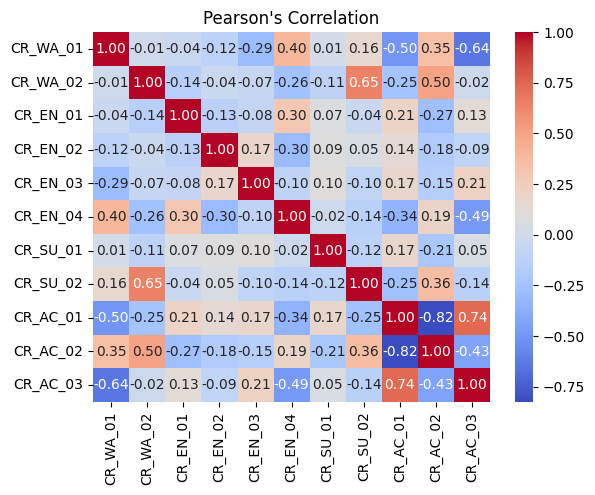

In [54]:
cr_df = alternatives_gdf_qnt.drop(columns=['standard_name', 'geometry'])

# Pearson's correlation: for linear relationships, suffers from outliers
pearson_corr = cr_df.corr(method='pearson')

#plt.figure(figsize=(8, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson's Correlation")
plt.show()

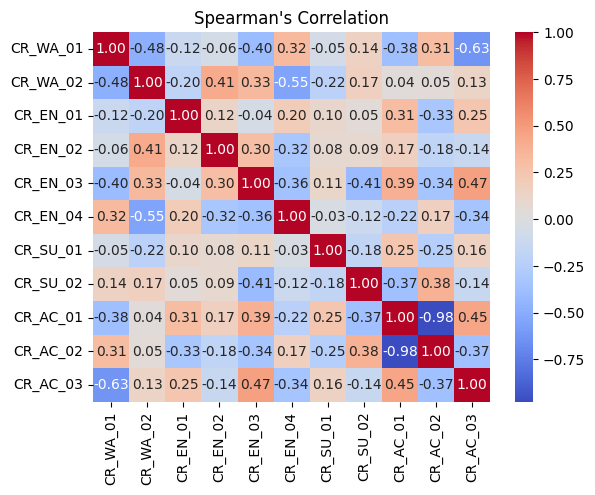

In [53]:
# Spearman correlation: for non-linear relationships, robust to outliers
spearman_corr = cr_df.corr(method='spearman')

#plt.figure(figsize=(8, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman's Correlation")
plt.show()

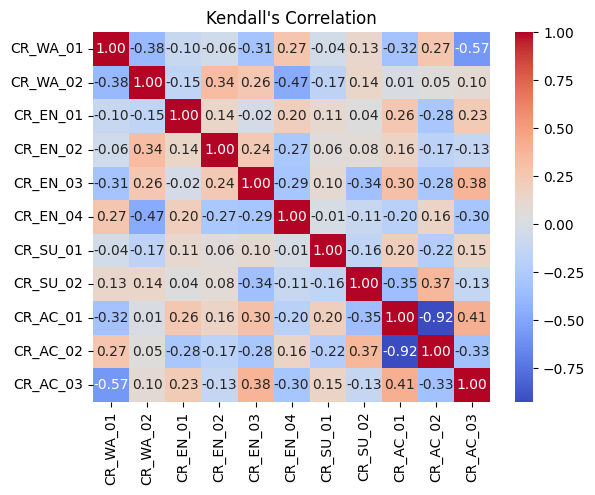

In [52]:
# Kendall correlation: non-linear relationships, robust for small datasets
kendall_corr = cr_df.corr(method='kendall')

#plt.figure(figsize=(8, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Kendall's Correlation")
plt.show()

The resulting correlation matrices are not extremely different, especially for Kendall and Spearman (both assume non-linear relationships). From quick scatter plots of the indicators, it appears that my data is not linear, thus Pearson's correlation may not be considered. The choice between Kendall and Spearman is less critical: because Kendall's tau is more robust for small datasets, i choose to consider it.

Observations:
Strong relations for values near +-1
- CR_AC_01 (type of accesses) and CR_AC_02 (num of accesses): −0.923 --> Strong negative association, suggesting that as one increases, the other decreases.
- CR_EN_03 (power storage capacity) and CR_AC_03 (cat cai/sat): 0.379 --> Moderate positive association, suggesting that these two variables move together.

Values near 0 indicate little to no monotonic relationship.

Most criteria are weakly correlated, for MCDM analysis uncorrelated criteria: (i) indicate distinct, independent factors. (ii) Allow for simpler aggregation and clearer decision-making. (iii) Enable flexibility in weighting and combining criteria.

# MCDM Analysis
Using [pymcdm](https://pymcdm.readthedocs.io/en/master/readme_link.html#usage-example) library.

Things to define:
- MCDM method
- normalization technique
- weights


In [2]:
# Create decision/alternatives matrix
alternatives_gdf_qnt = gpd.read_parquet('../data/alternatives_qnt.parquet')
alts = alternatives_gdf_qnt.drop(columns=['standard_name', 'geometry'])
alts = alts.apply(pd.to_numeric, errors='coerce')
alts = alts.to_numpy()  

In [5]:
alternatives_gdf_qnt.head(1)

,standard_name,geometry,CR_WA_01,CR_WA_02,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,CR_SU_01,CR_SU_02,CR_AC_01,CR_AC_02,CR_AC_03
0,alpepozzavlancia,POINT (666584.351 5077095.370),3,40.0,1.67,3,41.8,1,2.0,1.5,4.0,1,3


## Compute Rankings
By the literature review of MCDM methods, candidate models to adopt are:

American school:
- **TOPSIS**: produces a ranking based on a synthesized index (score from 0 to 1). The ranking is computed according to the closeness score to *ideal* and distance to anti-ideal. So in this case the preference function to be chosen is the type of distance (Euclidean, Manhattan, etc.).

    --> output: preference scores (better alternatives have *higher* values).

- **VIKOR**: similar to TOPSIS, also produces a ranking based on the closeness score (positive values) to the *best option*. This means it aims at finding a compromise solution closest to ideal but considering worst-performing criteria (avoids solutions that may be excellent in one criterion but poor in another). Uses Euclidean distance. 

    --> output: preference scores (better alternatives have *smaller* values).

European school:
- **PROMETHEE II**: model based on pairwise comparison (outranking). For each criterion, weights and a preference function are defined. The *preference function* for the i-th criterion is computed for each alternative and the weighted sum over all criteria defines the *aggregated preference index* of alternative a over alternative b. Using *outranking flows* it is possible to obtain a partial ranking (PROMETHEE I) or a complete ranking (PROMETHEE II) based on such pairwise preference/dominance relations.

Thus, before applying the model I will define a preference function (and thresholds) for each criteria, based on the type of measure and ranges. This criteria-specific selection is not supported for PROMETHEE on pymcdm, I implemented a workaround in the function `apply_prometheeii`: 
1. Apply PROMETHEE I individually for each criterion using the specific preference function and thresholds.
2. Aggregate the positive and negative flows from each criterion to compute the PROMETHEE II scores.


In [7]:
from pymcdm.methods import TOPSIS, VIKOR, COPRAS, PROMETHEE_II
from pymcdm import weights as w
from pymcdm import visuals

# Define weights 
custom_weights = {
    'CR_WA_01': 0.30,
    'CR_WA_02': 0.05, 
    'CR_EN_01': 0.30,
    'CR_EN_02': 0.00,
    'CR_EN_03': 0.05,
    'CR_EN_04': 0.05, 
    'CR_SU_01': 0.10, 
    'CR_SU_02': 0.10, 
    'CR_AC_01': 0.05, 
    'CR_AC_02': 0.00, 
    'CR_AC_03': 0.00}

custom_weights2 = {
    'CR_WA_01': 0.25,
    'CR_WA_02': 0.05, 
    'CR_EN_01': 0.25,
    'CR_EN_02': 0.00,
    'CR_EN_03': 0.05,
    'CR_EN_04': 0.05, 
    'CR_SU_01': 0.10, 
    'CR_SU_02': 0.10, 
    'CR_AC_01': 0.10, 
    'CR_AC_02': 0.00, 
    'CR_AC_03': 0.05}
assert round(np.array(list(custom_weights2.values())).sum(), 1) == 1, f"Weights do not sum to 1: {custom_weights2.sum()}"

weights_list = [
    w.equal_weights(alts),  
    w.entropy_weights(alts),
    w.critic_weights(alts),
    np.array(list(custom_weights2.values()))]
weights_names = ['equal', 'entropy', 'critic', 'custom']

# Define criteria types (benefit=1 or cost=-1)
types = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1]) # type of access and remoteness are costs

# Define methods
methods_list = [
    TOPSIS(),
    VIKOR(),
    'PROMETHEE_II'
]
methods_names = ['TOPSIS', 'VIKOR', 'PROMETHEE_II']


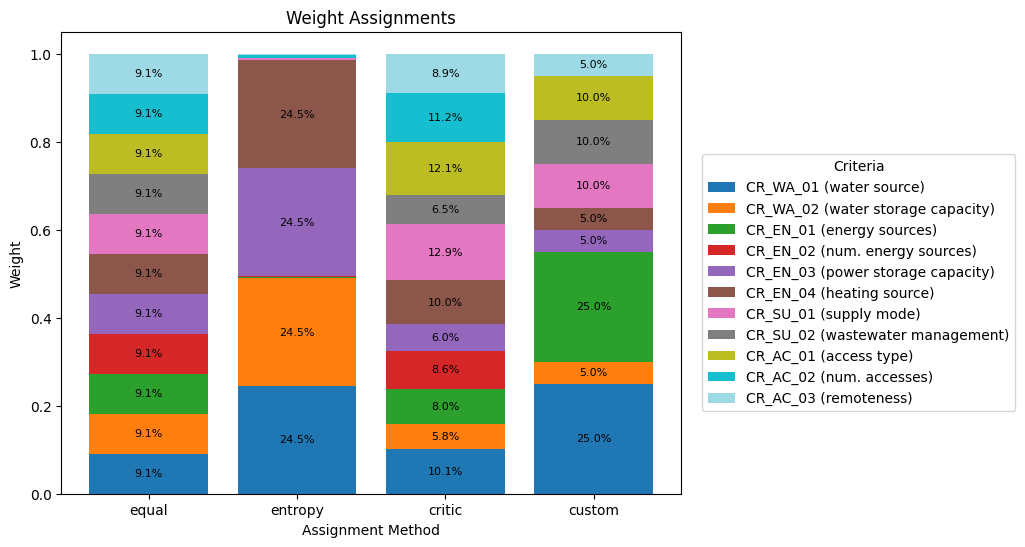

In [23]:
## Visualize criteria weights (with annotations)
num_weights = len(weights_list)
c_names = [col for col in alternatives_gdf_qnt.columns if 'CR_' in col and 'CR_HO' not in col]
num_criteria = len(c_names)
colors = plt.cm.tab20(np.linspace(0, 1, num_criteria))  

# Custom labels
custom_labels = {
    "CR_WA_01": "water source",
    "CR_WA_02": "water storage capacity",
    "CR_EN_01": "energy sources",
    "CR_EN_02": "num. energy sources",
    "CR_EN_03": "power storage capacity",
    "CR_EN_04": "heating source",
    "CR_SU_01": "supply mode",
    "CR_SU_02": "wastewater management",
    "CR_AC_01": "access type",
    "CR_AC_02": "num. accesses",
    "CR_AC_03": "remoteness",
}

# Set up plot
fig, ax = plt.subplots(figsize=(8, 6))

for i, weights in enumerate(weights_list):
    bottom = np.zeros(num_weights)
    for j, c_name in enumerate(c_names):
        ax.bar(i, weights[j], bottom=bottom[i], 
                label=c_names[j] if i == 0 else "", color=colors[j], width=0.8)
        bottom[i] += weights[j]  # stack each on top of the previous weight
        # conditionally annotate
        if weights[j] >= 0.05:
            ax.text(i, bottom[i] - weights[j] / 2, f"{weights[j]*100:.1f}%", 
                    ha='center', va='center', color='black', fontsize=8)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
customized_labels = [f"{label} ({custom_labels[label]})" for label in labels]  # map each CR to its description
ax.legend(handles, customized_labels, loc="upper right", bbox_to_anchor=(1.55, 0.75), title='Criteria')

ax.set_xticks(range(num_weights))
ax.set_xticklabels(weights_names)
ax.set_ylabel('Weight')
ax.set_xlabel('Assignment Method')
ax.set_title('Weight Assignments')
#ax.legend(loc="upper right", bbox_to_anchor=(1.25, 0.75), title='Criteria')

plt.show()

In [ ]:
# Plot only custom weights (pie)
# Extract labels and values from the dictionary (if weight > 0)
labels = [label for label, value in custom_weights2.items() if value > 0.00]
values = [value for value in custom_weights2.values() if value > 0.00]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Criteria Weights Distribution")
plt.show()

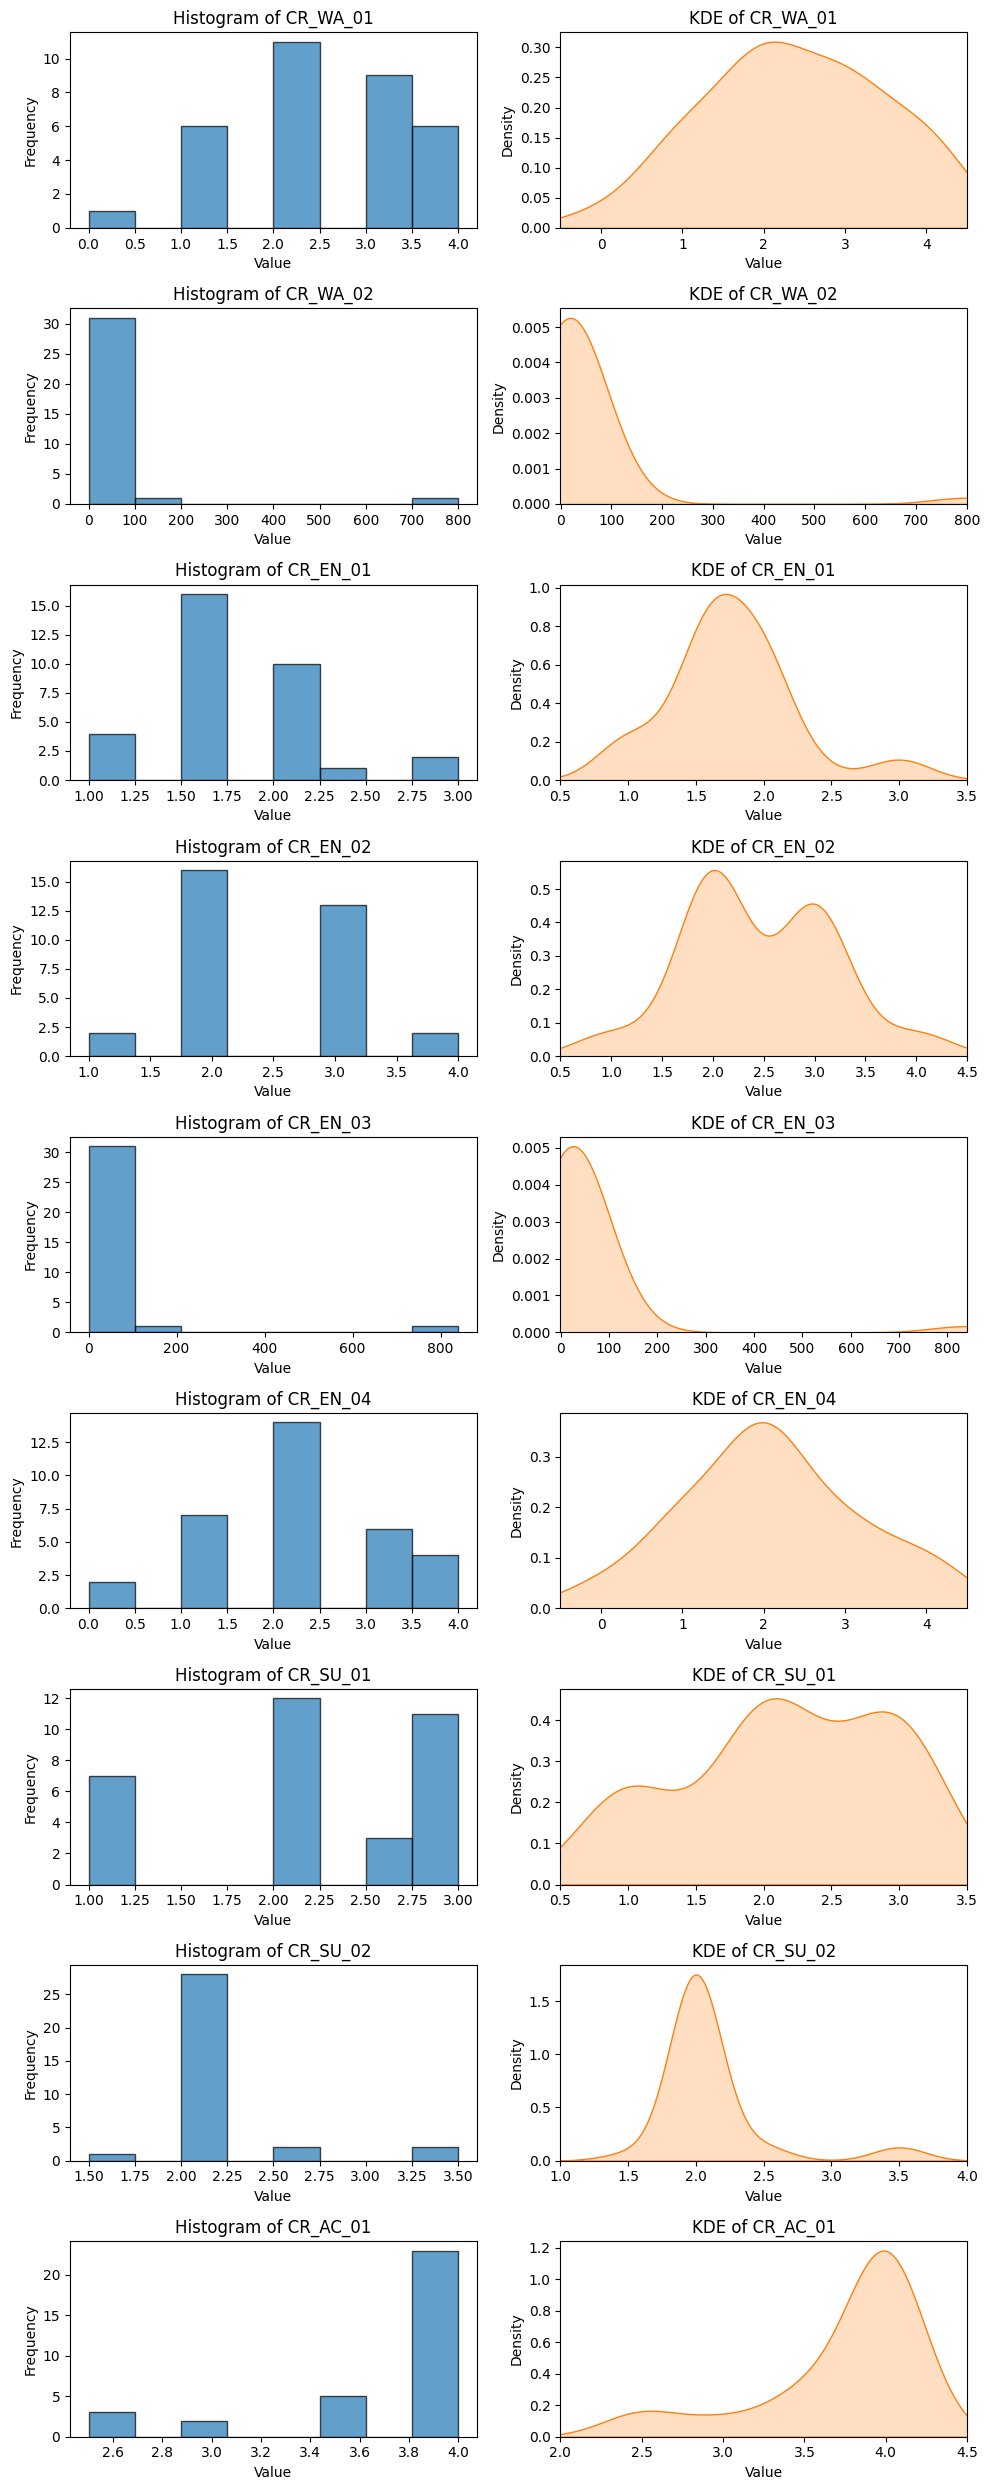

In [24]:
# Create a figure with both histogram and KDE for a detailed view of the distribution
c_names = alternatives_gdf_qnt.columns[2:-2]
fig, ax = plt.subplots(len(c_names), 2, figsize=(10,25))
for i, c_name in enumerate(c_names):
    criterion_values = alternatives_gdf_qnt[c_name]
    # Histogram
    ax[i,0].hist(criterion_values, bins=8, color="#1f77b4", alpha=0.7, edgecolor="black")
    ax[i,0].set_title(f"Histogram of {c_name}")
    ax[i,0].set_xlabel("Value")
    ax[i,0].set_ylabel("Frequency")

    # KDE (Kernel Density Estimate) plot
    sns.kdeplot(criterion_values, fill=True, color="#ff7f0e", ax=ax[i,1])
    ax[i,1].set_xlim(min(criterion_values)-0.5, max(criterion_values)+0.5)
    ax[i,1].set_title(f"KDE of {c_name}")
    ax[i,1].set_xlabel("Value")
    ax[i,1].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [25]:
## PROMETHEE II set-up
# Define preference functions and thresholds
criteria_config = {
    'water_source': {
        'preference_function': 'vshape',#level     # order of pref: 0, 1 < 2, 3 < 4  (no source, fusion < superficial < acqueduct)
        'p_threshold': 1,#1.5,                 # preference only when moving to next pref class
        'q_threshold': None,#1                    # differences within the same equivalence category do not show preference
    },
    'water_storage_capacity': {
        'preference_function': 'vshape_2',  # favour larger capacity (do not care for small differences)
        'p_threshold': 30,                  # differences of 30 units [m3] or more are treated as meaningful    
        'q_threshold': 5                   # small differences within 15 units are ignored
    },
    'energy_source': {
        'preference_function': 'vshape',#vshape_2',     # divide between non-renewables, public el and renewables
        'p_threshold': 1,#0.75,                # strong preferences are only for scores that span most of a level
        'q_threshold': None#0.25                 # small differences within the same category or mixed scores aren’t prioritized
    },
    'number_of_sources': {
        'preference_function': 'vshape',  # reward alternatives with higher source counts (reliability)
        'p_threshold': 1,                   # Preference with a full unit increase 
        'q_threshold': None      
    },
    'power_storage_capacity': {
        'preference_function': 'vshape_2',  # favour larger capacity (do not care for small differences)
        'p_threshold': 40,     
        'q_threshold': 20     
    },
    'heating_source': {
        'preference_function': 'vshape',    # gas < electric / public electricity / ren option
        'p_threshold': 1,    
        'q_threshold': None                
    },
    'supply_mode': {
        'preference_function': 'vshape',#'level', 
        'p_threshold': 1,   
        'q_threshold': None #0.5     
    },
    'waste_waters':{
        'preference_function': 'vshape', 
        'p_threshold': 1,   
        'q_threshold': None 
    },
    'types_of_access': {
        'preference_function': 'level',     # easy(car) < moderate (lifts) < hiking (only)
        'p_threshold': 0.50,   
        'q_threshold': 0.25     
    },
    'number_of_accesses': {
        'preference_function': 'vshape',    # favour more access points
        'p_threshold': 1,     
        'q_threshold': None
    },
    'remoteness': {
        'preference_function': 'ushape',
        'p_threshold': None,      
        'q_threshold': 1       
    }
}

def apply_prometheeii(alts, weights, types, criteria_config:dict):
    ''' Function to apply PROMETHEE_II method using different preference functions for each criteria.
        Computes positive and negative flows for each criteria (partial rankings), 
        then aggregates them in net flow (complete ranking).
        
        Returns:
        - net_flows: array of preference score for each alternative. '''

    # Initialize positive and negative flow accumulators
    positive_flows = np.zeros(alts.shape[0])
    negative_flows = np.zeros(alts.shape[0])

    # Calculate PROMETHEE I flows for each criterion separately
    for idx, (criterion, config) in enumerate(criteria_config.items()):
        # Initialize PROMETHEE II with the current criterion's preference function
        promethee = PROMETHEE_II(config['preference_function'])
        
        # Positive and negative flows array for idx criterion
        pos_flow, neg_flow = promethee(alts[:, [idx]], np.array([weights[idx]]), np.array([types[idx]]), 
                                    p=np.array([config['p_threshold']]), q=np.array([config['q_threshold']]), promethee_I=True)

        # Weighted sum of positive and negative flows (PROMETHEE I scores)
        positive_flows += pos_flow * weights[idx]
        negative_flows += neg_flow * weights[idx]
        

    # Net outranking flow (PROMETHEE II preference score: the higher, the better)
    net_flows = positive_flows - negative_flows 

    return net_flows, positive_flows, negative_flows

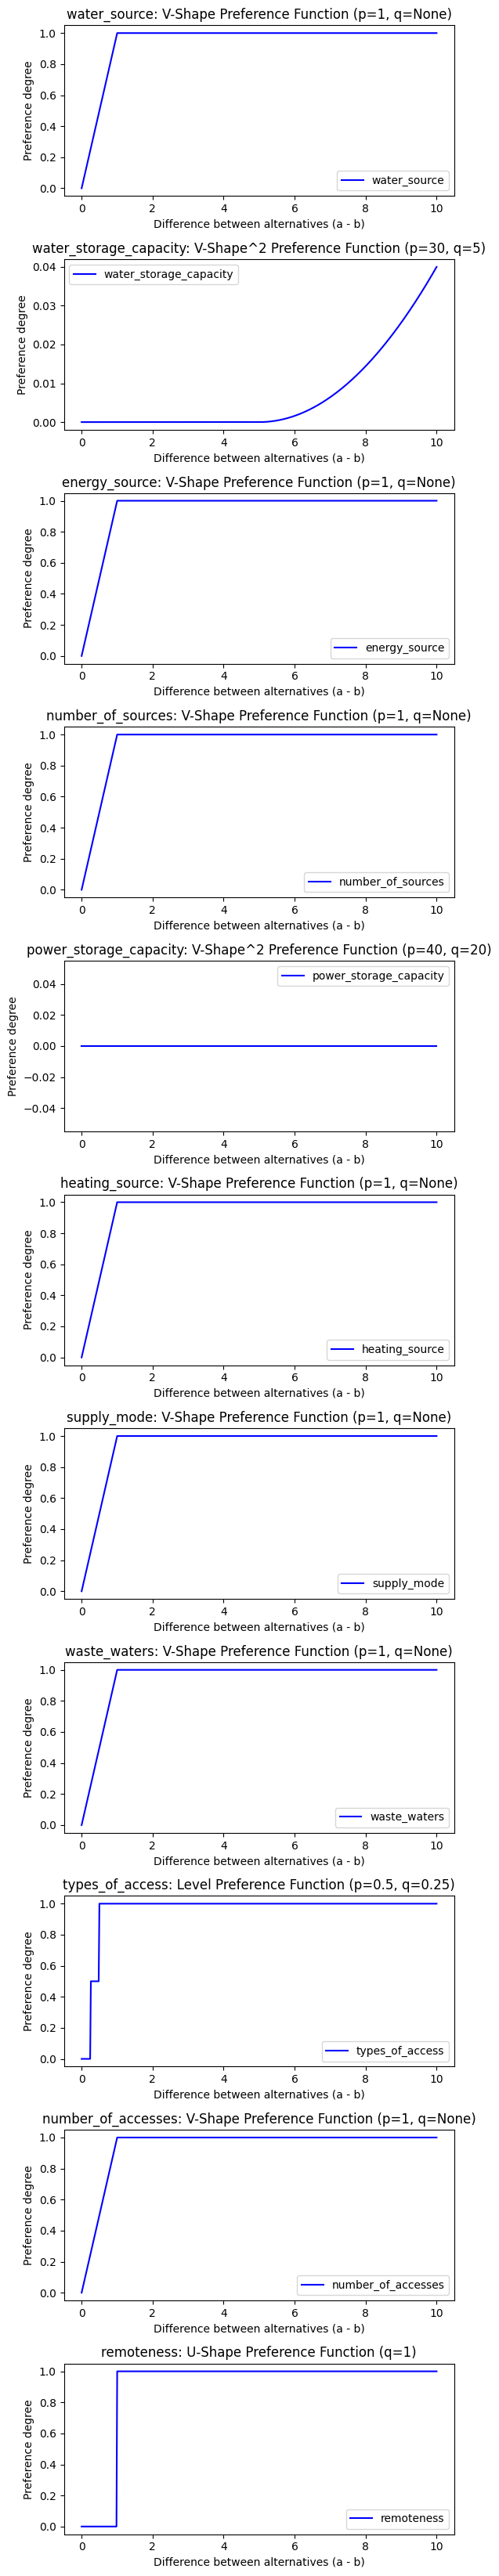

In [26]:
def plot_preference_functions(criteria_config):
    x = np.linspace(0, 10, 500)  # Example range for differences between alternatives
    fig, axs = plt.subplots(len(criteria_config), 1, figsize=(6, len(criteria_config) * 3))

    for i, (criterion, config) in enumerate(criteria_config.items()):
        p_og = config['p_threshold']
        q_og = config['q_threshold']
        pref_func = config['preference_function']

        p = p_og if p_og is not None else 0
        q = q_og if q_og is not None else 0

        if pref_func == 'vshape':
            y = np.clip((x - q) / (p - q), 0, 1)
            title = f"V-Shape Preference Function (p={p_og}, q={q_og})"
        elif pref_func == 'vshape_2':
            y = np.clip((x - q) / (p - q), 0, 1)**2
            title = f"V-Shape^2 Preference Function (p={p_og}, q={q_og})"
        elif pref_func == 'level':
            y = np.where(x <= q, 0, np.where(x >= p, 1, 0.5))
            title = f"Level Preference Function (p={p_og}, q={q_og})"
        elif pref_func == 'ushape':
            y = np.where(x <= q, 0, 1)
            title = f"U-Shape Preference Function (q={q_og})"
        else:
            y = np.zeros_like(x)  # Placeholder for other functions
            title = f"{pref_func} Preference Function (p={p_og}, q={q_og})"
        
        axs[i].plot(x, y, label=criterion, color='b')
        axs[i].set_title(f"{criterion}: {title}")
        axs[i].set_xlabel("Difference between alternatives (a - b)")
        axs[i].set_ylabel("Preference degree")
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot each criterion's preference function with its thresholds
plot_preference_functions(criteria_config)


In [56]:
# Execute analysis for different methods and weights
prefs = []
ranks = []
confs = []

for i, method in enumerate(methods_list):
    for y, weights in enumerate(weights_list):
        if method == 'PROMETHEE_II':
            pref, pos_flows, neg_flows = apply_prometheeii(alts, weights, types, criteria_config)
            # method = PROMETHEE_II('usual')
            # pref = method(alts, weights, types)
            rank = np.argsort(pref)[::-1] + 1
        else:
            # Apply other methods 
            pref = method(alts, weights, types)
            rank = method.rank(pref)

        prefs.append(pref)
        ranks.append(rank)
        confs.append(methods_names[i] + '_' + weights_names[y])

# Create Dataframes of results
a = alternatives_gdf_qnt['standard_name']
pref_df = pd.DataFrame(zip(*prefs), columns=confs, index=a).round(3)
rank_df = pd.DataFrame(zip(*ranks), columns=confs, index=a).astype('int')
rank_df = rank_df.sort_values(by='TOPSIS_custom')

In [31]:
# Save results
rank_df.to_csv("../results/rank_df.csv")
pref_df.to_csv("../results/pref_df.csv")

## Analyze Results

In [2]:
# Load results
rank_df = pd.read_csv("../results/rank_df.csv", index_col='standard_name')
pref_df = pd.read_csv("../results/pref_df.csv", index_col='standard_name')

In [ ]:
# Get Latex table
DF = rank_df
table_big = tabulate(DF, headers="keys", tablefmt="latex")

df_method = DF[[col for col in DF.columns if 'VIKOR' in col]]
table_method = tabulate(df_method, headers="keys", tablefmt="latex")
print(table_method)


### Rank analysis
**Spearman rank correlation**: the correlation between results obtained with different configurations is a measure of similarity between rankings. I use Spearman correlation. Higher correlation means models produce similar rankings.

In [ ]:
import scipy.stats as stats

# Compute the Spearman rank correlation matrix
corr_matrix = np.zeros((len(ranks), len(ranks)))
for i in range(len(ranks)):
    for j in range(len(ranks)):
        corr_matrix[i, j], _ = stats.spearmanr(ranks[i], ranks[j])

# Convert to DataFrame
df_corr = pd.DataFrame(corr_matrix, index=confs, columns=confs)

# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 6))
#mask = np.triu(np.ones_like(df_corr, dtype=bool), k=1)
sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm', cbar=True, linewidths=.5, mask=None)
plt.xticks(rotation=45, ha='right')
plt.title('Spearman Rank Correlation')
plt.show()


In [129]:
high_corr = ['TOPSIS_equal','TOPSIS_critic', 'VIKOR_equal', 'VIKOR_critic']
eq_cr = df_corr.loc[high_corr, high_corr]
print(f"Mean Spearman correlation between TOPSIS and VIKOR with equal and critic weights: {eq_cr.to_numpy().mean()}")

low_corr = ['TOPSIS_custom','TOPSIS_entropy', 'VIKOR_custom', 'VIKOR_entropy']
eq_cr = df_corr.loc[low_corr, low_corr]
print(f"Mean Spearman correlation between TOPSIS and VIKOR with entropy and custom weights: {eq_cr.to_numpy().mean()}")

Mean Spearman correlation between TOPSIS and VIKOR with equal and critic weights: 0.9524903894367375
Mean Spearman correlation between TOPSIS and VIKOR with entropy and custom weights: 0.6288233327761993


**Pairwise rank comparison**

In [37]:
# Pairwise rank comparison plot
def plot_pairwise_ranks(rank1:str, rank2:str, rank_df): 
    rank1_res, rank2_res = rank_df[rank1], rank_df[rank2]

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150, tight_layout=True)
    ax.grid(zorder=1, alpha=0.5)
    ax.plot([0, 33], [0, 33], linestyle='--', color='gray', zorder=2)

    sns.scatterplot(x=rank1_res, y=rank2_res, zorder=3, ax=ax)

    ax.set_xticks(np.arange(0, 34, 1))
    ax.set_yticks(np.arange(0, 34, 1))
    ax.tick_params(axis='both', labelsize=6)

    # Annotate each point with the corresponding 'standard_name' from alternatives_gdf
    for name in rank1_res.index:
        ax.annotate(name, 
                    (rank_df.loc[name, rank1], rank_df.loc[name, rank2]), 
                    textcoords="offset points", 
                    xytext=(10, 2),  # offset 
                    ha='center', fontsize=6, zorder=4)

    plt.title(f'Rank Comparison (Spearman Correlation={round(stats.spearmanr(rank1_res, rank2_res)[0], 2)})')
    plt.xlabel(rank1, fontsize=8)
    plt.ylabel(rank2, fontsize=8)
    plt.show()

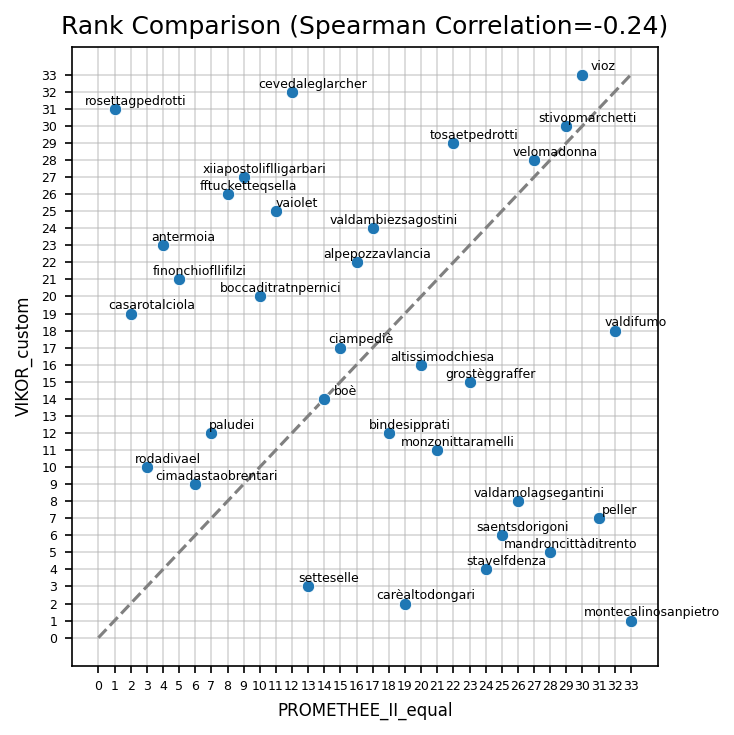

In [40]:
selected_confs = [('PROMETHEE_II_equal', 'VIKOR_custom')]

for rank1, rank2 in selected_confs:
    plot_pairwise_ranks(rank1, rank2, rank_df)

Overview of all rankings with **standard deviation**.

In [41]:
# Rank standard deviation & average position
rank_df['rank_stdev'] = round(rank_df.std(axis=1), 2)

rank_nostd = rank_df[[col for col in rank_df.columns if col != 'rank_stdev']]
rank_df['avg_position'] = round(rank_df.mean(axis=1), 0)

rank_df_sorted = rank_df.sort_values(by='rank_stdev', ascending=True)

In [ ]:
# Latex table with hut-std-mean
selected = rank_df_sorted[[col for col in rank_df_sorted if col in ['rank_stdev', 'avg_position']]]
table = tabulate(selected, headers="keys", tablefmt="latex")
print(table)

In [18]:
# Plot heatmap for all ranks
def plot_all_ranks(rank_df, title:str=None):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(rank_df, annot=True, cmap='RdYlGn_r', cbar=True, linewidths=.5)

    ax.xaxis.tick_top() 
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)
    if title:
        plt.title(title)
    else:
        plt.title('Ranking Positions ordered on Standard Deviation')
    plt.show()

plot_all_ranks(rank_df_sorted)

# Latex table
table_method = tabulate(rank_df_sorted, headers="keys", tablefmt="latex")
print(table_method)

NameError: name 'rank_df_sorted' is not defined

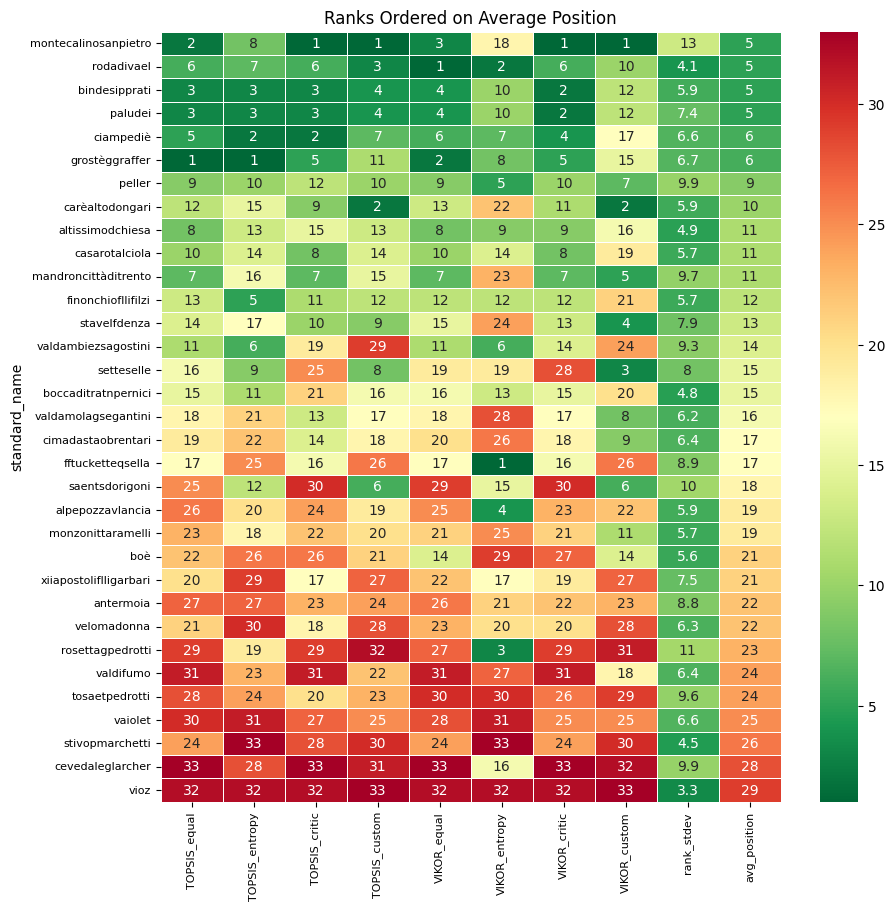

In [54]:
# Plot ranks ordered on average position (no promethee)
rank_noprom = rank_df.drop(columns=[col for col in rank_df.columns if 'PROMETHEE' in col])
rank_noprom['avg_position'] = round(rank_noprom.mean(axis=1), 0)
rank_noprom.sort_values(by='avg_position', inplace=True)
plot_all_ranks(rank_noprom, title='Ranks Ordered on Average Position')


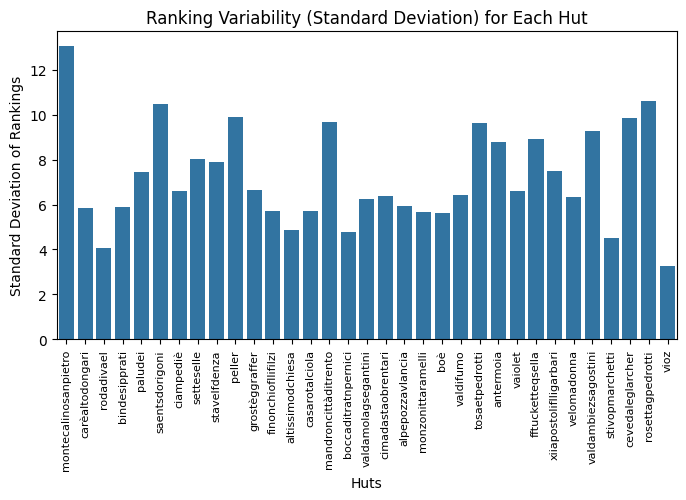

In [55]:
# Plot standard deviation
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=rank_df.index, y=rank_df['rank_stdev'])
ax.tick_params(axis='x', labelsize=8, labelrotation=90)
plt.title('Ranking Variability (Standard Deviation) for Each Hut')
plt.ylabel('Standard Deviation of Rankings')
plt.xlabel('Huts')
plt.show()


### Preference scores comparison
I can plot the preference scores of different alternatives for the different configurations. 
Note: in VIKOR lower preference scores indicate a better alternative (contrary of TOPSIS, COPRAS). Thus I will not include them in these plots because they might be misleading.

In [60]:
## Preference scores
def plot_pref_scores(alternatives_to_plot, pref_df):
    non_vikor_df = pref_df.loc[:, ~pref_df.columns.str.contains('VIKOR')]

    ax = non_vikor_df.T[alternatives_to_plot].plot(kind='line', marker='o')
    plt.title('Preference Scores for Selected Alternatives')
    plt.xlabel('Configuration')
    plt.ylabel('Preference Score')
    plt.legend(title='Alternatives')

    num_ticks = len(non_vikor_df.columns)  
    ax.set_xticks(np.linspace(0, len(non_vikor_df.T.index) - 1, num_ticks, dtype=int))
    ax.set_xticklabels(labels=non_vikor_df.columns, rotation=80)

    plt.show()

### Focus on custom weights rankings

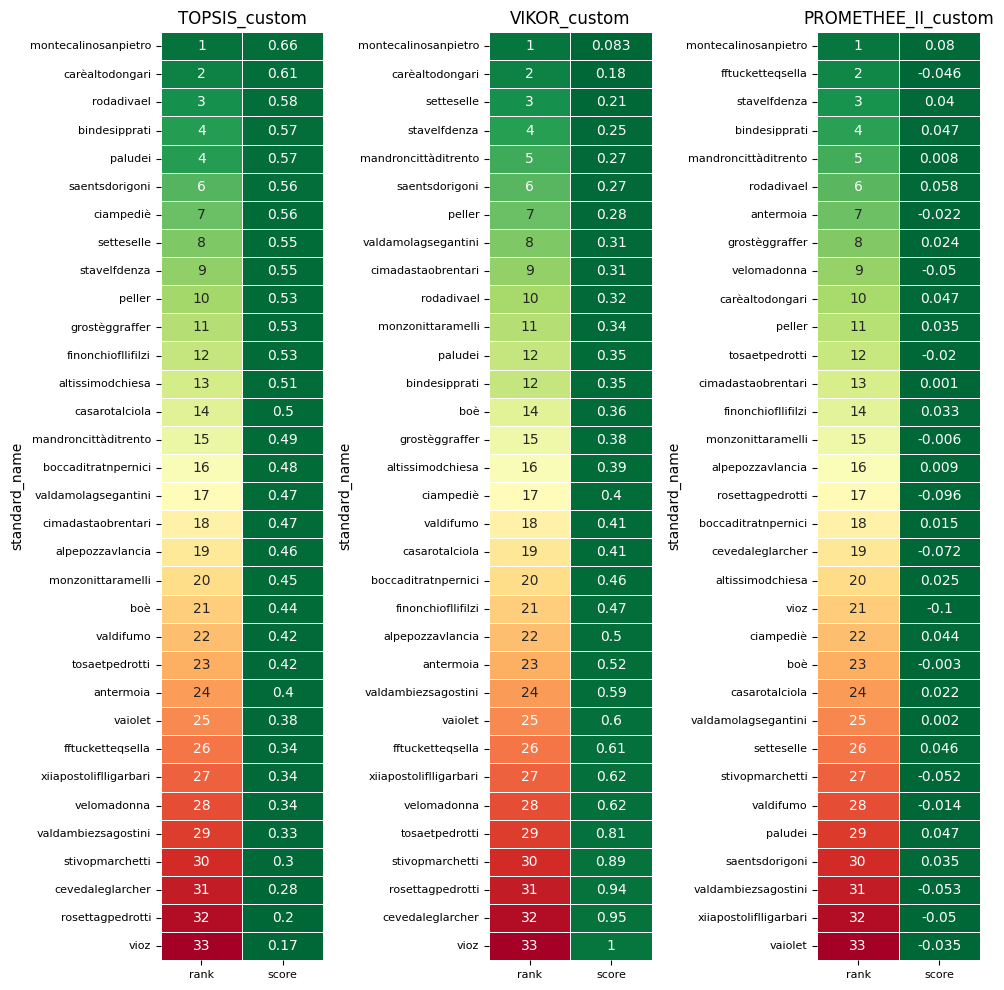

In [5]:
def plot_multiple_ranks(selected_confs:list, rank_df, pref_df):
    '''Plot ranks and preference scores for selected models '''
    fig, ax = plt.subplots(1, len(selected_confs), figsize=(10,10))
    for i, conf_name in enumerate(selected_confs):
        data = pd.DataFrame({'rank': rank_df[conf_name],
                            'score': pref_df[conf_name]}, index=rank_df.index)
        data.sort_values(by='rank', inplace=True)
        sns.heatmap(data, ax=ax[i], 
            annot=True, cmap='RdYlGn_r', cbar=False, linewidths=.5,
            xticklabels=True)
        ax[i].tick_params(axis='y', labelsize=8)
        ax[i].tick_params(axis='x', labelsize=8)
        ax[i].set_title(conf_name)

    plt.tight_layout()
    plt.show()

#selection = set([item for sublist in selected_confs for item in sublist]) #unique names
selection = ['TOPSIS_custom', 'VIKOR_custom', 'PROMETHEE_II_custom']
plot_multiple_ranks(selection, rank_df, pref_df)

In [14]:
# Rank standard deviation & average position
ranks_custom = rank_df[selection]
ranks_custom['rank_stdev'] = round(ranks_custom.std(axis=1), 2)

rank_nostd = ranks_custom[[col for col in ranks_custom.columns if col != 'rank_stdev']]
ranks_custom['avg_position'] = round(rank_nostd.mean(axis=1), 0)

ranks_custom_sorted = ranks_custom.sort_values(by='avg_position', ascending=True)

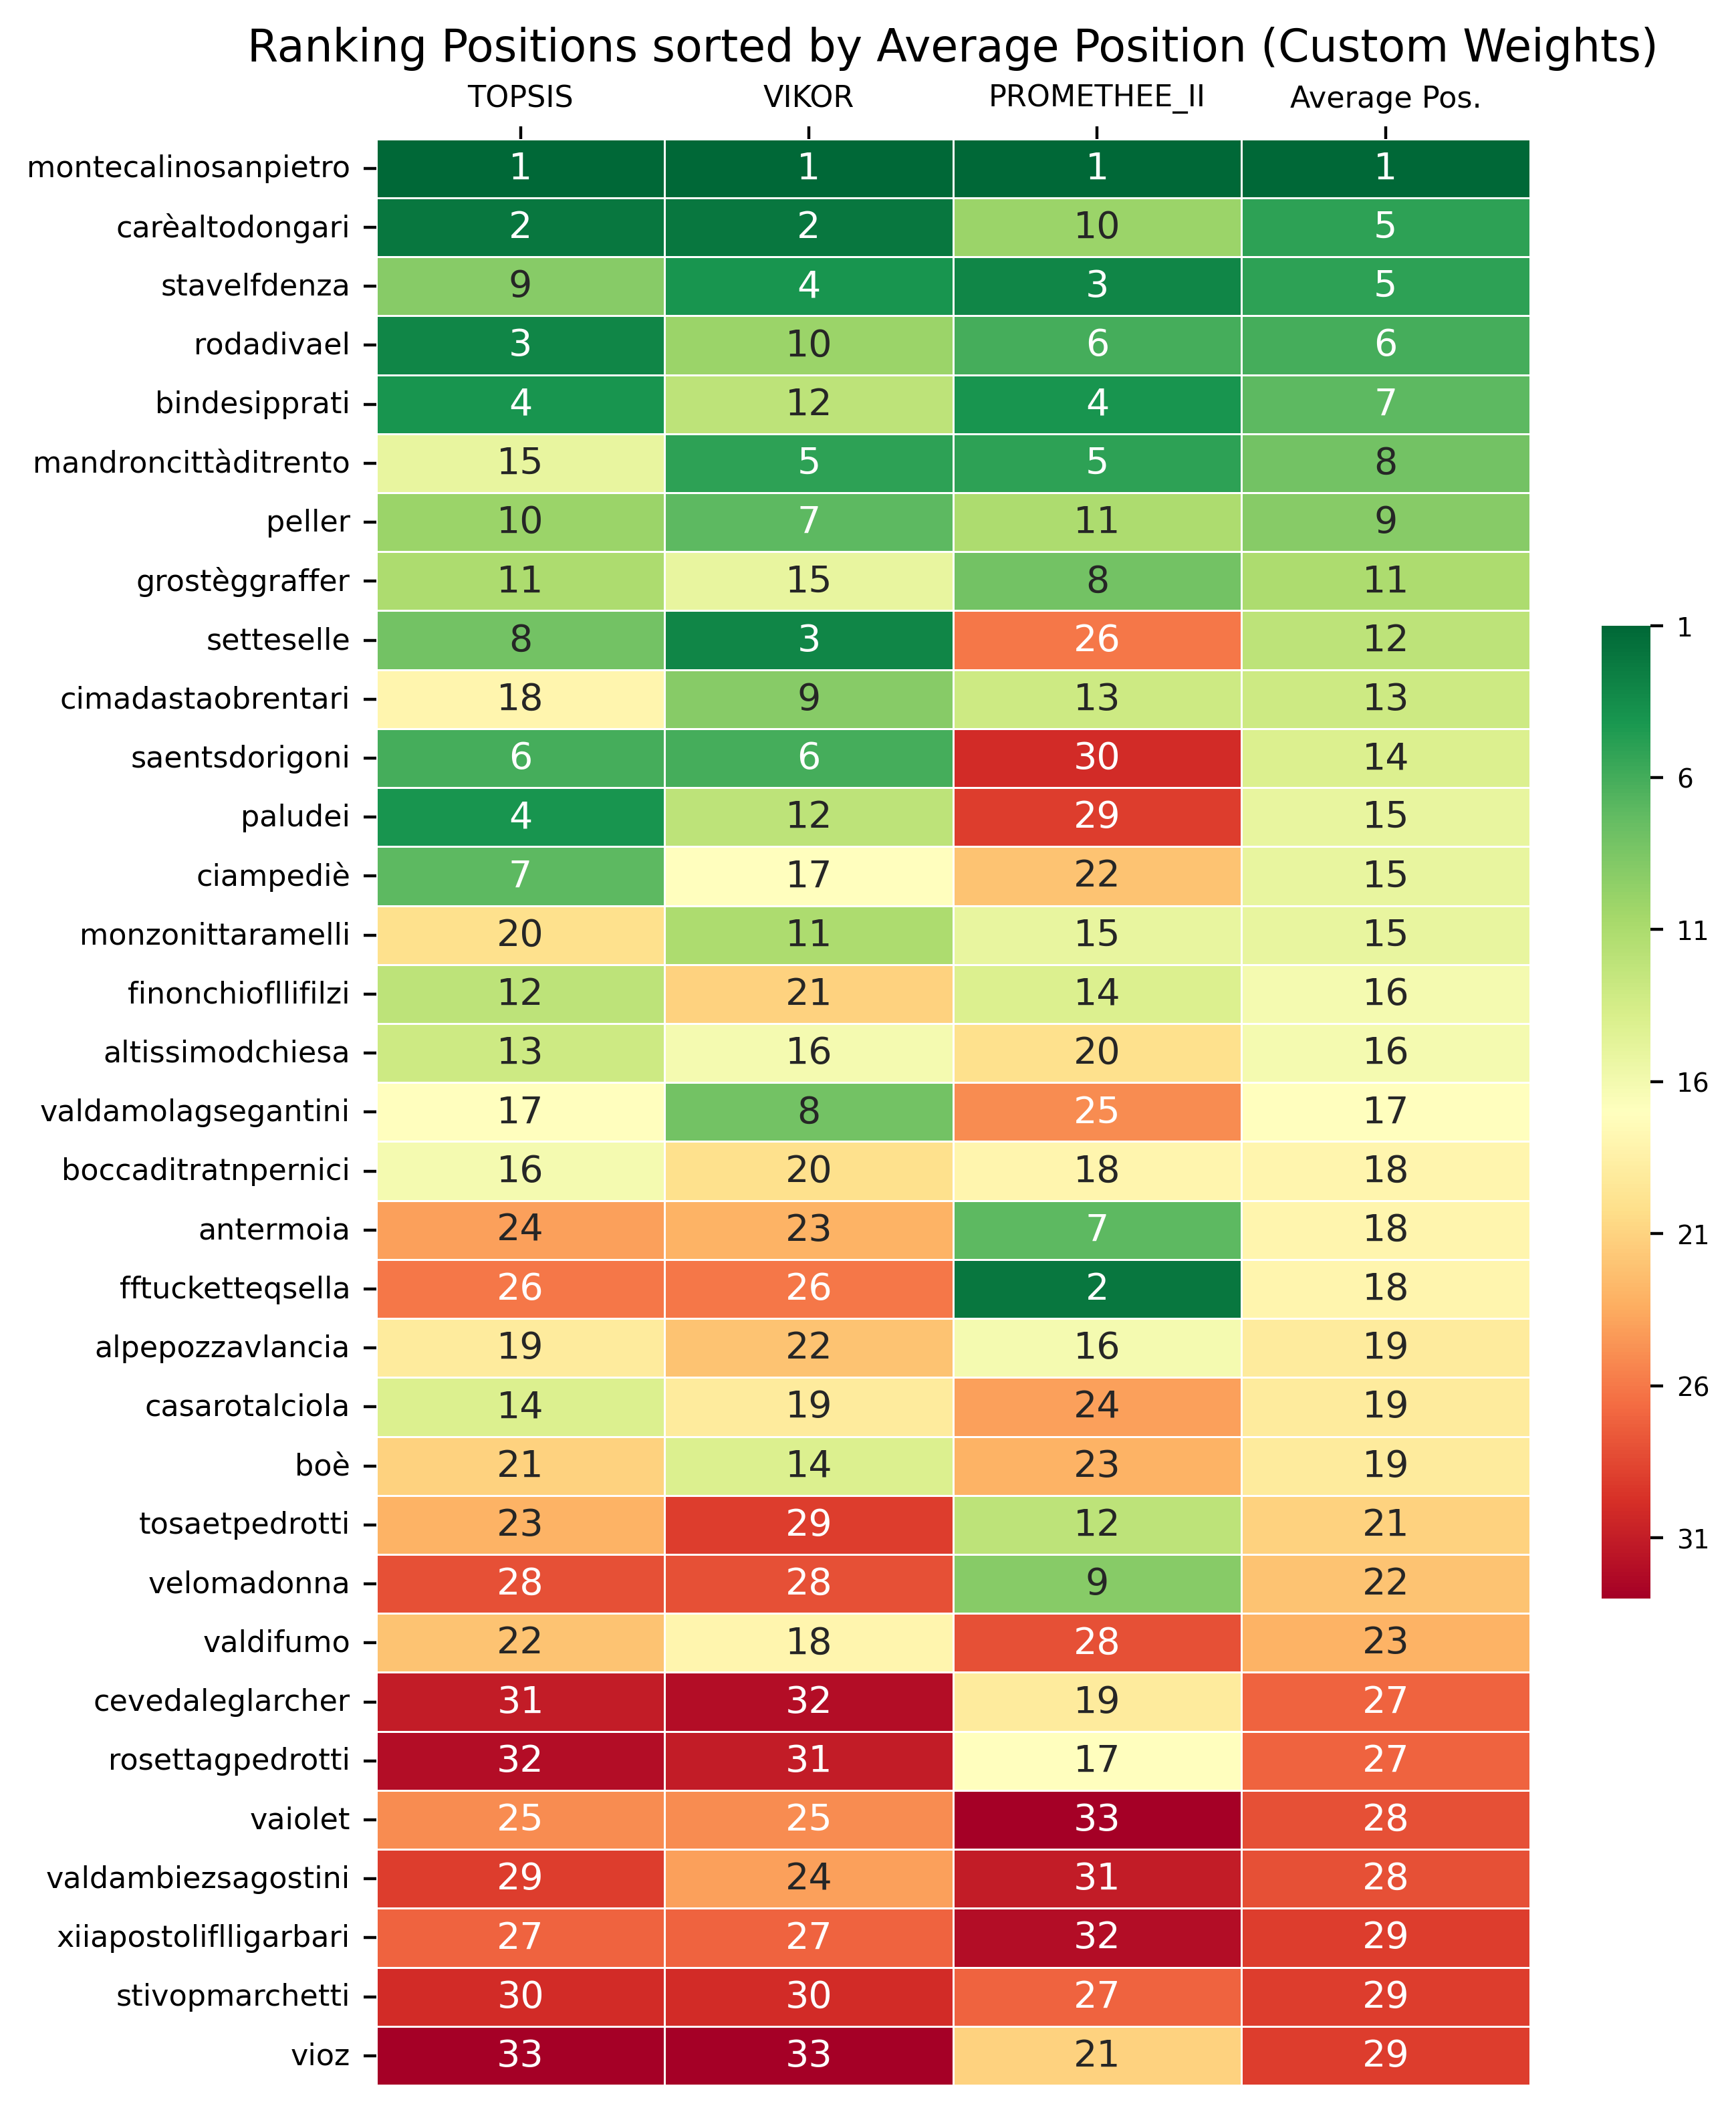

In [84]:
# Plot the 3 ranks, sorted by average position
def plot_ranks_by_avgpos(rank_df):
    plt.figure(figsize=(7, 8), dpi=400)
    ax = sns.heatmap(rank_df, annot=True, 
                    cmap='RdYlGn_r', cbar=True, cbar_kws={"shrink": 0.5, "ticks": range(1, 33, 5)}, 
                    linewidths=.5)

    # Invert the color bar axis
    cbar = ax.collections[0].colorbar
    cbar.ax.invert_yaxis()
    cbar.ax.tick_params(labelsize=7)  

    # # Highlight the avg_position column (overlay a second heatmap)
    # avg_col_index = rank_df.columns.get_loc("avg_position")  
    # mask = np.ones_like(rank_df, dtype=bool)
    # mask[:, avg_col_index] = False  # Keep avg_position column unmasked
    # sns.heatmap(
    #     rank_df,
    #     mask=mask,
    #     annot=False,
    #     cmap=['gray'],  # different colormap 
    #     cbar=False,
    #     linewidths=0.5,
    #     ax=ax
    # )

    ax.xaxis.tick_top() 
    ax.set_xticklabels(['TOPSIS', 'VIKOR', 'PROMETHEE_II', 'Average Pos.'])
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_ylabel(None)
    plt.title('Ranking Positions sorted by Average Position (Custom Weights)')
    plt.tight_layout()
    plt.show()

ranks_custom_nostd = ranks_custom_sorted.drop(columns='rank_stdev')
plot_ranks_by_avgpos(ranks_custom_nostd)

### Profile of an alternative (PROMETHEE)
The profile of an alternative, in PROMETHEE, consists of the **set of all the single criterion net flows**, computed as if 100% of the total weight is allocated to that criterion. It expresses how an alternative is outranking or outranked by all the other alternatives on that criterion. This is useful to assess, for a specific hut, which are its strong and weak criteria.

In [62]:
# Compute single criterion flows without weights (1 criterion, weight=1)
criteria_flows = {}
for idx, (criterion, config) in enumerate(criteria_config.items()):
    promethee = PROMETHEE_II(config['preference_function']) 
    pos_flow, neg_flow = promethee(alts[:, [idx]], np.array([1]), np.array([types[idx]]), 
                                    p=np.array([config['p_threshold']]), q=np.array([config['q_threshold']]), promethee_I=True)
    
    criteria_flows[f'C{idx+1}'] = pos_flow - neg_flow


def plot_profile_alternative(alt_name:str, criteria_flows:dict):
    alt_index = alternatives_gdf[alternatives_gdf['standard_name'] == alt_name].index[0]
    alternative_profile = [criterion_flows[alt_index] for C, criterion_flows in criteria_flows.items()]
    criteria_names = list(criteria_flows.keys())

    plt.figure(figsize=(6, 3))
    plt.bar(criteria_names, alternative_profile, color='skyblue')
    plt.axhline(0, color='grey', linewidth=0.8)  # Reference line at zero
    plt.xlabel('Criteria')
    plt.ylabel('Net Flow')
    plt.title(f'PROMETHEE - Profile of an Alternative: {alt_name}')
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()

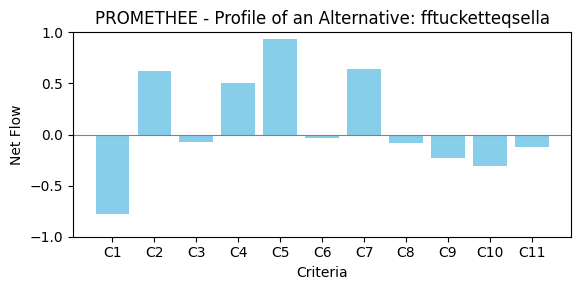

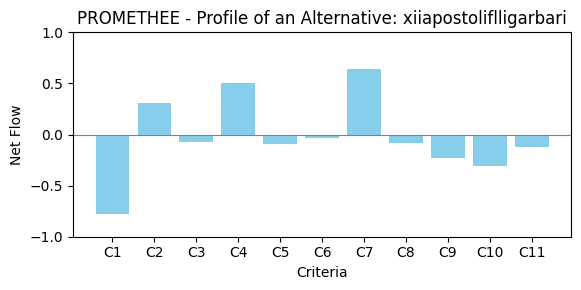

In [63]:
plot_profile_alternative('fftucketteqsella', criteria_flows)
plot_profile_alternative('xiiapostoliflligarbari', criteria_flows)

### Spider plot

In [122]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm

def plot_radar_criteria(alternatives_gdf_qnt, selected_huts):
    ''' Plots radar chart showing normalized criteria for different huts. '''

    data = alternatives_gdf_qnt.drop(columns=[col for col in alternatives_gdf_qnt.columns if 'HO' in col])
    data = data.drop(columns='geometry')
    data.set_index('standard_name', inplace=True)
    data = data.apply(pd.to_numeric, errors='coerce')

    # Normalize the data across each criterion (column-wise)
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)  

    # Prepare angles for each axis, repeat first angle to close the circle
    num_criteria = len(data.columns)
    angles = np.linspace(0, 2 * np.pi, num_criteria, endpoint=False).tolist()
    angles += angles[:1]

    cmap = plt.get_cmap('viridis', len(selected_huts))

    # Radar plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for i, hut_name in enumerate(selected_huts):
        # Get normalized values for the specific hut
        normalized_hut = normalized_data[data.index == hut_name].flatten()
        normalized_hut = np.concatenate((normalized_hut, [normalized_hut[0]]))  # Close the radar chart loop

        ax.fill(angles, normalized_hut, color=cmap(i), alpha=0.25, label=hut_name)
        ax.plot(angles, normalized_hut, color=cmap(i), linewidth=2)
        ax.plot(angles[:-1], normalized_hut[:-1], 'o', color=cmap(i), markersize=5)  # Marker points

    # Set criteria and radius labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(data.columns, fontsize=10)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)

    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.1))
    plt.title('Criteria Radar Plot for Selected Huts')
    plt.show()

In [146]:
top_5_names = list(rank_noprom.iloc[0:5].index)
alternatives_gdf[alternatives_gdf['standard_name'].isin(['mandroncittàditrento', 'saentsdorigoni', 'monzonittaramelli', 'cimadastaobrentari'])]

,standard_name,geometry,CR_WA_01,CR_WA_02,CR_EN_01,CR_EN_02,CR_EN_03,CR_EN_04,CR_SU_01,CR_SU_02,CR_AC_01,CR_AC_02,CR_AC_03
10,cimadastaobrentari,POINT (701043.977 5116266.942),lago,10.0,"[hydroelectric, gas]",2,7.0,renewable_option,[aerialway],"[septic_tank, grid, grease_separator]",[trail],1,4
14,mandroncittàditrento,POINT (621213.949 5117752.751),torr-lago,NaN,"[hydroelectric, gas]",2,25.0,elettrico,[aerialway],"[septic_tank, grid, grease_separator]","[trail, lift_2300m]",2,4
16,monzonittaramelli,POINT (710684.696 5141542.381),torr-rio,NaN,"[hydroelectric, gas]",2,6.0,elettrico,[vehicle],"[septic_tank, grid, grease_separator]",[trail],1,3
21,saentsdorigoni,POINT (634522.416 5146722.339),lago-torr,17.0,[hydroelectric],1,40.0,elettrico,[helicopter],"[septic_tank, grid, grease_separator]",[trail],1,4


   standard_name                        geometry CR_WA_01  CR_WA_02  \
30   velomadonna  POINT (719190.082 5123681.117)  fusione      30.0   

                          CR_EN_01  CR_EN_02  CR_EN_03          CR_EN_04  \
30  [generator, photovoltaic, gas]         3      21.3  renewable_option   

       CR_SU_01                               CR_SU_02 CR_AC_01  CR_AC_02  \
30  [aerialway]  [septic_tank, grid, grease_separator]  [trail]         1   

    CR_AC_03  
30         4  


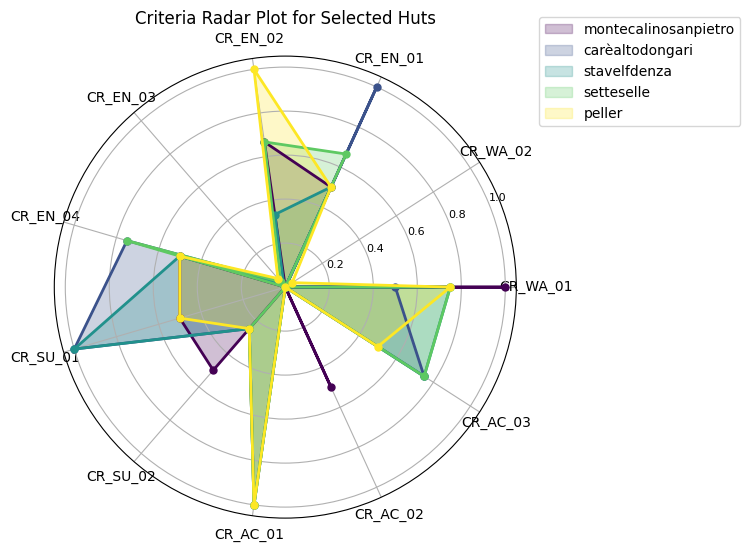

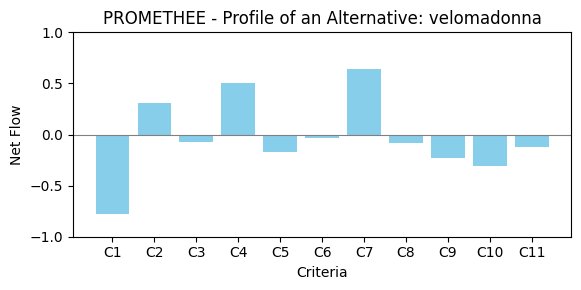

In [143]:
hut_name = 'velomadonna'
print(alternatives_gdf[alternatives_gdf['standard_name']==hut_name])

plot_radar_criteria(alternatives_gdf_qnt, top_5_names)
plot_profile_alternative(hut_name, criteria_flows)


Some comments:
- Rank correlation matrix: high correlations among equal-weight and critic-weight configurations across TOPSIS, COPRAS, and VIKOR imply these configurations produce more consistent rankings and are likely more robust. COPRAS_custom has similarly high correlations.

    PROMETHEE_II has low correlation, meaning its rankings generally differ from the other models. This is potentially due to its preference function handling, which is often more sensitive to specific criteria thresholds rather than incremental distances.

- About rankings: many huts are consistent in their ranking among the various configurations, especially the ones in top and bottom positions. This is also confirmed by the rank correlation among different models and weights. This consistency for best and worst huts can be observed also for PROMETHEE rankings, despite the low rank correlation.

- About preference scores: must be careful in comparing preference scores among methods because the scale differs. In VIKOR, a lower score indicates a better alternative, whereas in COPRAS and TOPSIS a lower score means a worse alternative. Comparing rankings is more reliable.

- Profile of alternative: this plot is a useful tool to visualize the quality of criterias for a single alternative, this information can enrich the ranking produced by PROMETHEE models.



# Sensitivity analysis
Aim: assess how sensitive the rankings or preferences are to changes in the **weight vectors** and the choice of **method**.
- Impact of Weight Variations: compare how much the rankings change when the weight vector changes, holding the method constant. --> how sensitive the rankings are to changes in the weight distribution.
- Impact of Method Variations: compare how much the rankings change when the method changes, holding the weights constant. --> sensitivity of rankings to the choice of method.



In [83]:
from scipy.stats import spearmanr

# Define the method (or weight type) you want to keep constant
method = 'PROMETHEE_II'  # or TOPSIS, VIKOR, critic, etc..
method_columns = [col for col in rank_df.columns if method in col]

# Initialize a list to store the correlation results
correlation_results = []

# Loop through weight configurations and calculate rank correlations
for i in range(len(method_columns)):
    for j in range(i + 1, len(method_columns)):
        weight_config1 = method_columns[i]
        weight_config2 = method_columns[j]
        
        # Calculate Spearman's rank correlation for the two configurations
        correlation, _ = spearmanr(rank_df[weight_config1], rank_df[weight_config2])
        correlation_results.append({
            'Config 1': weight_config1,
            'Config 2': weight_config2,
            'Spearman Rank Correlation': round(correlation, 2)
        })

# Convert the results to a DataFrame for easy visualization
correlation_df = pd.DataFrame(correlation_results)

In [81]:
correlation_df_sorted = correlation_df.sort_values(by='Spearman Rank Correlation', ascending=False)
table = tabulate(correlation_df_sorted, headers="keys", tablefmt="latex", showindex=False)
print(table)

\begin{tabular}{llr}
\hline
 Config 1       & Config 2       &   Spearman Rank Correlation \\
\hline
 TOPSIS\_equal   & TOPSIS\_critic  &                        0.91 \\
 TOPSIS\_equal   & TOPSIS\_entropy &                        0.81 \\
 TOPSIS\_entropy & TOPSIS\_custom  &                        0.77 \\
 TOPSIS\_equal   & TOPSIS\_custom  &                        0.74 \\
 TOPSIS\_critic  & TOPSIS\_custom  &                        0.71 \\
 TOPSIS\_entropy & TOPSIS\_critic  &                        0.67 \\
\hline
\end{tabular}


In [ ]:
# Visualize the correlation results as a heatmap
# You can reshape the data to create a matrix form for a heatmap
corr_matrix = correlation_df.pivot(index='Weight Config 1', columns='Weight Config 2', values='Spearman Rank Correlation')

# Plot heatmap of Spearman rank correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Spearman Rank Correlation for {method}')
plt.show()

Rank Difference:
- Rank Difference: absolute difference in rankings between two weight configurations for each alternative. These differences are calculated for each alternative and method pair.

I sort them based on Mean Rank Difference.

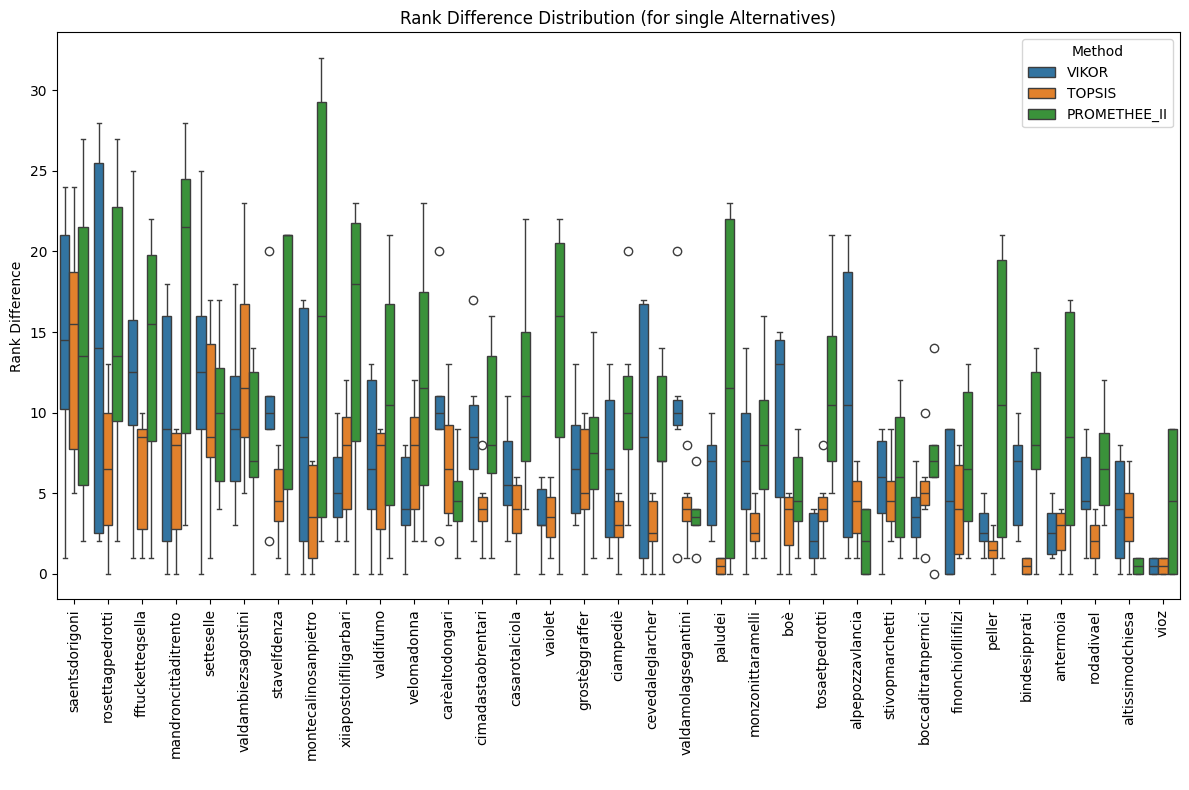

In [112]:
# Prepare data for all methods
methods = ['TOPSIS', 'VIKOR', 'PROMETHEE_II']  # Add other methods as needed
rank_diff_results = []

for method in methods:
    method_columns = [col for col in rank_df.columns if method in col]
    for alt in rank_df.index:
        for i in range(len(method_columns)):
            for j in range(i + 1, len(method_columns)):
                weight_config1 = method_columns[i]
                weight_config2 = method_columns[j]
                rank_diff = abs(rank_df.at[alt, weight_config1] - rank_df.at[alt, weight_config2])
                rank_diff_results.append({
                    'Alternative': alt,
                    'Weight Config 1': weight_config1,
                    'Weight Config 2': weight_config2,
                    'Rank Difference': rank_diff,
                    'Method': method  # Add the method as a column
                })

# Convert to DataFrame for visualization
rank_diff_df = pd.DataFrame(rank_diff_results)
# sort by mean rank difference
rank_diff_df['Mean Rank Difference'] = rank_diff_df.groupby('Alternative')['Rank Difference'].transform('mean')
rank_diff_df = rank_diff_df.sort_values(by='Mean Rank Difference', ascending=False)

# Plot rank differences with hue for methods
plt.figure(figsize=(12, 8))
sns.boxplot(x='Alternative', y='Rank Difference', hue='Method', data=rank_diff_df, palette='tab10')

plt.title('Rank Difference Distribution (for single Alternatives)')
plt.xticks(rotation=90) #ha="right"
plt.xlabel(' ')
plt.ylabel('Rank Difference')
plt.legend(title='Method')
plt.tight_layout()
plt.show()